In [1]:
from adodbapi.ado_consts import directions
from cartopy import crs as ccrs
import cartopy.feature as cfeature
import multiprocessing
import sys
import cartopy.feature as cfeature
import cmaps
import matplotlib.pyplot as plt
import numpy as np
import tqdm as tq
import xarray as xr
from cartopy.io.shapereader import Reader
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter  # 专门提供经纬度的
from cartopy.util import add_cyclic_point
from matplotlib import gridspec
from matplotlib import ticker
from matplotlib.pyplot import quiverkey
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.ndimage import filters

from toolbar.significance_test import corr_test
from toolbar.TN_WaveActivityFlux import TN_WAF_3D
from toolbar.curved_quivers.modplot import *
from toolbar.data_read import *
from toolbar.lonlat_transform import transform as lonlat_trs


K_type = xr.open_dataset(r"D:/PyFile/p2/data/Time_type_AverFiltAll0.9%_0.3%_3.nc")

In [ ]:
# z
z_low = era5_p("E:/data/ERA5/ERA5_pressLev/era5_pressLev.nc", 1961, 2022, [200, 500, 850], 'z')
z_high = era5_hp("E:/data/ERA5/ERA5_pressLev/era5_pressLev_high.nc", 1961, 2022, [100, 150], 'z')
z = xr.concat([z_high, z_low], dim='level')
# u
u_low = era5_p("E:/data/ERA5/ERA5_pressLev/era5_pressLev.nc", 1961, 2022, [200, 500, 850], 'u')
u_high = era5_hp("E:/data/ERA5/ERA5_pressLev/era5_pressLev_high.nc", 1961, 2022, [100, 150], 'u')
u = xr.concat([u_high, u_low], dim='level')
# v
v_low = era5_p("E:/data/ERA5/ERA5_pressLev/era5_pressLev.nc", 1961, 2022, [200, 500, 850], 'v')
v_high = era5_hp("E:/data/ERA5/ERA5_pressLev/era5_pressLev_high.nc", 1961, 2022, [100, 150], 'v')
v = xr.concat([v_high, v_low], dim='level')
# t
t_low = era5_p("E:/data/ERA5/ERA5_pressLev/era5_pressLev.nc", 1961, 2022, [200, 500, 850], 't')
t_high = era5_hp("E:/data/ERA5/ERA5_pressLev/era5_pressLev_high.nc", 1961, 2022, [100, 150], 't')
t = xr.concat([t_high, t_low], dim='level')
# pre
pre = prec("E:/data/NOAA/PREC/precip.mon.anom.nc", 1961, 2022)
# sst
sst = ersst("E:/data/NOAA/ERSSTv5/sst.mnmean.nc", 1961, 2022)
Z = z.sel(time=slice('1961-01-01', '2022-12-31'))
Z = Z.sel(time=Z['time.month'].isin([7, 8])).groupby('time.year').mean('time').transpose('year', 'level', 'lat', 'lon')
U = u.sel(time=slice('1961-01-01', '2022-12-31'))
U = U.sel(time=U['time.month'].isin([7, 8])).groupby('time.year').mean('time').transpose('year', 'level', 'lat', 'lon')
V = v.sel(time=slice('1961-01-01', '2022-12-31'))
V = V.sel(time=V['time.month'].isin([7, 8])).groupby('time.year').mean('time').transpose('year', 'level', 'lat', 'lon')
T = t.sel(time=slice('1961-01-01', '2022-12-31'))
T = T.sel(time=T['time.month'].isin([7, 8])).groupby('time.year').mean('time').transpose('year', 'level', 'lat', 'lon')
Pre = pre.sel(time=slice('1961-01-01', '2022-12-31')).sel(time=pre['time.month'].isin([7, 8])).groupby(
    'time.year').mean('time').transpose('year', 'lat', 'lon')
Sst = sst.sel(time=slice('1961-01-01', '2022-12-31')).sel(time=sst['time.month'].isin([7, 8])).groupby(
    'time.year').mean('time').transpose('year', 'lat', 'lon')
Z.to_netcdf(r"D:/PyFile/p2/data/Z.nc")
U.to_netcdf(r"D:/PyFile/p2/data/U.nc")
V.to_netcdf(r"D:/PyFile/p2/data/V.nc")
T.to_netcdf(r"D:/PyFile/p2/data/T.nc")
Pre.to_netcdf(r"D:/PyFile/p2/data/pre.nc")
Sst.to_netcdf(r"D:/PyFile/p2/data/sst.nc")

In [10]:
Z = xr.open_dataset(r"D:/PyFile/p2/data/Z.nc").sel(level=[100, 150, 200, 500, 850])
U = xr.open_dataset(r"D:/PyFile/p2/data/U.nc").sel(level=[100, 150, 200, 500, 850])
V = xr.open_dataset(r"D:/PyFile/p2/data/V.nc").sel(level=[100, 150, 200, 500, 850])
T = xr.open_dataset(r"D:/PyFile/p2/data/T.nc").sel(level=[100, 150, 200, 500, 850])
Pre = xr.open_dataset(r"D:/PyFile/p2/data/pre.nc")
Sst = xr.open_dataset(r"D:/PyFile/p2/data/sst.nc")
surface_radio = xr.open_dataset(r"D:/PyFile/p2/data/Surface_Radio.nc") * -1  # 为下垫面放热为正，吸热为负

In [3]:
def regress(time_series, data):
    # 将 data 重塑为二维：时间轴为第一个维度
    reshaped_data = data.reshape(len(time_series), -1)

    # 减去均值以中心化（标准化自变量和因变量）
    time_series_mean = time_series - np.mean(time_series)
    data_mean = reshaped_data - np.mean(reshaped_data, axis=0)

    # 计算分子（协方差的分子）
    numerator = np.sum(data_mean * time_series_mean[:, np.newaxis], axis=0)

    # 计算分母（自变量的平方和）
    denominator = np.sum(time_series_mean ** 2)

    # 计算回归系数
    regression_coef = numerator / denominator
    correlation = numerator / (np.sqrt(np.sum(data_mean ** 2, axis=0)) * np.sqrt(np.sum(time_series_mean ** 2)))
    # 重塑为 (lat, lon)
    regression_map = regression_coef.reshape(data.shape[1:])
    correlation_map = correlation.reshape(data.shape[1:])
    return regression_map, correlation_map

def corr(time_series, data):
    # 计算相关系数
    # 将 data 重塑为二维：时间轴为第一个维度
    reshaped_data = data.reshape(len(time_series), -1)

    # 减去均值以标准化
    time_series_mean = time_series - np.mean(time_series)
    data_mean = reshaped_data - np.mean(reshaped_data, axis=0)

    # 计算分子（协方差）
    numerator = np.sum(data_mean * time_series_mean[:, np.newaxis], axis=0)

    # 计算分母（标准差乘积）
    denominator = np.sqrt(np.sum(data_mean ** 2, axis=0)) * np.sqrt(np.sum(time_series_mean ** 2))

    # 相关系数
    correlation = numerator / denominator

    # 重塑为 (lat, lon)
    correlation_map = correlation.reshape(data.shape[1:])
    return correlation_map

def latlon_fmt(ax, xticks1, yticks1, xmajorLocator, xminorLocator, ymajorLocator, yminorLocator):
    if yticks1 is not None: ax.set_yticks(yticks1, crs=ccrs.PlateCarree())
    if xticks1 is not None: ax.set_xticks(xticks1, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_locator(ymajorLocator)
    ax.yaxis.set_minor_locator(yminorLocator)
    ax.xaxis.set_major_locator(xmajorLocator)
    ax.xaxis.set_minor_locator(xminorLocator)
    ax.tick_params(which='major', length=4, width=.5, color='black')
    ax.tick_params(which='minor', length=2, width=.2, color='black')
    ax.tick_params(which='both', bottom=True, top=False, left=True, labelbottom=True, labeltop=False)
    plt.rcParams['ytick.direction'] = 'out'
    ax.tick_params(axis='both', labelsize=9, colors='black')

def rec(ax, point, color='red'):
    x1, x2 = point[:2]
    y1, y2 = point[2:]
    x, y = [x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1]
    ax.plot(x, y, color=color, transform=ccrs.PlateCarree())

In [49]:
# 计算相关系数
corr_z_1 = np.zeros((len(Z['level']), len(Z['lat']), len(Z['lon'])))
corr_z_2 = np.zeros((len(Z['level']), len(Z['lat']), len(Z['lon'])))
reg_z_1 = np.zeros((len(Z['level']), len(Z['lat']), len(Z['lon'])))
reg_z_2 = np.zeros((len(Z['level']), len(Z['lat']), len(Z['lon'])))

corr_u_1 = np.zeros((len(U['level']), len(U['lat']), len(U['lon'])))
corr_u_2 = np.zeros((len(U['level']), len(U['lat']), len(U['lon'])))
reg_u_1 = np.zeros((len(U['level']), len(U['lat']), len(U['lon'])))
reg_u_2 = np.zeros((len(U['level']), len(U['lat']), len(U['lon'])))

corr_v_1 = np.zeros((len(V['level']), len(V['lat']), len(V['lon'])))
corr_v_2 = np.zeros((len(V['level']), len(V['lat']), len(V['lon'])))
reg_v_1 = np.zeros((len(V['level']), len(V['lat']), len(V['lon'])))
reg_v_2 = np.zeros((len(V['level']), len(V['lat']), len(V['lon'])))

corr_t_1 = np.zeros((len(T['level']), len(T['lat']), len(T['lon'])))
corr_t_2 = np.zeros((len(T['level']), len(T['lat']), len(T['lon'])))
reg_t_1 = np.zeros((len(T['level']), len(T['lat']), len(T['lon'])))
reg_t_2 = np.zeros((len(T['level']), len(T['lat']), len(T['lon'])))

corr_pre_1 = np.zeros((len(Pre['lat']), len(Pre['lon'])))
corr_pre_2 = np.zeros((len(Pre['lat']), len(Pre['lon'])))
reg_pre_1 = np.zeros((len(Pre['lat']), len(Pre['lon'])))
reg_pre_2 = np.zeros((len(Pre['lat']), len(Pre['lon'])))

corr_sst_1 = np.zeros((len(Sst['lat']), len(Sst['lon'])))
corr_sst_2 = np.zeros((len(Sst['lat']), len(Sst['lon'])))
reg_sst_1 = np.zeros((len(Sst['lat']), len(Sst['lon'])))
reg_sst_2 = np.zeros((len(Sst['lat']), len(Sst['lon'])))

corr_radio_1 = np.zeros((len(surface_radio['lat']), len(surface_radio['lon'])))
corr_radio_2 = np.zeros((len(surface_radio['lat']), len(surface_radio['lon'])))
reg_radio_1 = np.zeros((len(surface_radio['lat']), len(surface_radio['lon'])))
reg_radio_2 = np.zeros((len(surface_radio['lat']), len(surface_radio['lon'])))


# ## 东部型
# K_series = K_type.sel(type=1)['K'].data
# K_series = (K_series - np.mean(K_series))/np.std(K_series)
# #### 大西洋降水
#
# Sst = lonlat_trs(Sst, type='360->180')
# Pre = lonlat_trs(Pre, type='360->180')
# zone = [-110, 10, 30, 0]
# corr_NPW = regress(K_series, Pre['pre'].sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).data)[0]
# corr_NPW = np.where(corr_NPW > 0, corr_NPW, 0)
# time_series = ((Pre.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]))- Pre.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).mean(['year']))*corr_NPW).mean(['lat', 'lon'])['pre'].to_numpy()
# # #### 大西洋暖异常
# # zone = [-25, 10, 5, -5]
# # corr_NPW = regress(K_series, Sst['sst'].sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).data)[0]
# # time_series = ((Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]))- Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).mean(['year']))*corr_NPW).mean(['lat', 'lon'])['sst'].to_numpy()
# Sst = lonlat_trs(Sst, type='180->360')
# Pre = lonlat_trs(Pre, type='180->360')
# zone_1 = zone
# time_series_1 = (time_series - np.mean(time_series))/np.std(time_series)
# draw_zone_1 = [0, 360, -20, 80]
# c_lon_1 = 50
# np.save(r'D:\PyFile\p2\data\type1_P_warm.npy', time_series_1)
#
# #### 拉尼娜降水
# # zone = [70, 360-140, 10, -10]
# # corr_NPW = regress(K_series, Pre['pre'].sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).data)[0]
# # time_series = ((Pre.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]))- Pre.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).mean(['year']))*corr_NPW).mean(['lat', 'lon'])['pre'].to_numpy()
# zone = [160, 360-85, 5, -5]
# corr_LN = regress(K_series, Sst['sst'].sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).data)[0]
# time_series = ((Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]))- Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).mean(['year']))*corr_LN).mean(['lat', 'lon'])['sst'].to_numpy()
# zone_2 = zone
# time_series_2 = (time_series - np.mean(time_series))/np.std(time_series)
# draw_zone_2 = [0, 360, -20, 80]
# c_lon_2 = 50   #'''
#
# np.save(r'D:\PyFile\p2\data\type1_LN.npy', time_series_2)


# ## 全区一致型
# K_series = K_type.sel(type=2)['K'].data
# K_series = K_series[:-1]
# K_series = (K_series - np.mean(K_series))/np.std(K_series)
# # ### 印度洋降水
# # zone = [53, 83, 10, -10]
# # corr_NPW = regress(K_series, Pre['pre'].sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]), year=slice(1961, 2021)).data)[0]
# # time_series = ((Pre.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]), year=slice(1961, 2021))
# #                 - Pre.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]), year=slice(1961, 2021)).mean(['year']))*corr_NPW).mean(['lat', 'lon'])['pre'].to_numpy()
# #### 北大西洋暖
# zone = [-75, -10, 50, 25]
# Sst = lonlat_trs(Sst, type='360->180')
# Pre = lonlat_trs(Pre, type='360->180')
# corr_NPW = regress(K_series, Sst['sst'].sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]), year=slice(1961, 2021)).data)[0]
# # corr_NPW = np.where(corr_NPW > 0, corr_NPW, 0)
# sst_ano = Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]), year=slice(1961, 2021)) - Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]), year=slice(1961, 2021)).mean(['year'])
# time_series = (sst_ano*corr_NPW).mean(['lat', 'lon'])['sst'].to_numpy()
# # time_series = (Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]), year=slice(1961, 2021))
# #                 *corr_NPW).mean(['lat', 'lon'])['sst'].to_numpy()
# Sst = lonlat_trs(Sst, type='180->360')
# Pre = lonlat_trs(Pre, type='180->360')
# time_series = (time_series - np.mean(time_series))/np.std(time_series)
# zone_1 = zone
# time_series_1 = (time_series - np.mean(time_series))/np.std(time_series)
# draw_zone_1 = [0, 360, -20, 80]
# c_lon_1 = 100
#
# #### 拉尼娜
# zone = [120, 360-80, 10, -10]
# # zone = [120, 175, 10, -10]
# corr_LN = regress(K_series, Sst['sst'].sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]), year=slice(1961, 2021)).data)[0]
# sst_ano = Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]), year=slice(1961, 2021)) - Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]), year=slice(1961, 2021)).mean(['year'])
# # sst_ano = (sst_ano - sst_ano.mean(['year'])) / sst_ano.std(['year'])
# time_series = (sst_ano*corr_LN).mean(['lat', 'lon'])['sst'].to_numpy()
# # zone = [360-200, 360-80, 20, -15] # 东太降水
# # corr_LN = regress(K_series, Pre['pre'].sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).data)[0]
# # time_series = ((Pre.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]))- Pre.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).mean(['year']))*corr_LN).mean(['lat', 'lon'])['pre'].to_numpy()
# time_series = (time_series - np.mean(time_series))/np.std(time_series)#
# zone_2 = zone
# time_series_2 = (time_series - np.mean(time_series))/np.std(time_series)
# draw_zone_2 = [0, 360, -20, 80]
# c_lon_2 = 100   #'''
# np.save(r'D:\PyFile\p2\data\type2_In_pre.npy', time_series_1)
# np.save(r'D:\PyFile\p2\data\type2_LN.npy', time_series_2)

## 西部型
K_series = K_type.sel(type=3)['K'].data
K_series = (K_series - np.mean(K_series))/np.std(K_series)
#### 北大西洋暖
Sst = lonlat_trs(Sst, type='360->180')
Pre = lonlat_trs(Pre, type='360->180')
zone = [-70, -20, 55, 35]
corr_NPW = regress(K_series, Sst['sst'].sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).data)[0]
time_series = ((Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]))- Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).mean(['year']))*corr_NPW).mean(['lat', 'lon'])['sst'].to_numpy()
# zone = [-50, 10, 15, -10] # 大西洋干旱
# corr_LN = regress(K_series, Pre['pre'].sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).data)[0]
# time_series = ((Pre.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]))- Pre.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).mean(['year']))*corr_LN).mean(['lat', 'lon'])['pre'].to_numpy()
time_series = (time_series - np.mean(time_series))/np.std(time_series)
Sst = lonlat_trs(Sst, type='180->360')
Pre = lonlat_trs(Pre, type='180->360')
zone_1 = zone
time_series_1 = (time_series - np.mean(time_series))/np.std(time_series)
draw_zone_1 = [0, 360, -20, 80]
c_lon_1 = 100

#### 厄尔尼诺
zone = [180, 360-90, 5, -5]
corr_LN = regress(K_series, Sst['sst'].sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).data)[0]
time_series = ((Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]))- Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).mean(['year']))*corr_LN).mean(['lat', 'lon'])['sst'].to_numpy()

# zone = [80, 360-110, 10, -10] # nino
# Sst = lonlat_trs(Sst, type='360->180')
# Pre = lonlat_trs(Pre, type='360->180')
# corr_LN = regress(K_series, Pre['pre'].sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).data)[0]
# time_series = ((Pre.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]))- Pre.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).mean(['year']))*corr_LN).mean(['lat', 'lon'])['pre'].to_numpy()
# Sst = lonlat_trs(Sst, type='180->360')
# Pre = lonlat_trs(Pre, type='180->360')
time_series = (time_series - np.mean(time_series))/np.std(time_series)
zone_2 = zone
time_series_2 = (time_series - np.mean(time_series))/np.std(time_series)
draw_zone_2 = [0, 360, -20, 80]
c_lon_2 = 100   #'''
np.save(r'D:\PyFile\p2\data\type3_P_cold.npy', time_series_1)
np.save(r'D:\PyFile\p2\data\type3_EL.npy', time_series_2)

# 字体为新罗马
plt.rcParams['font.family'] = 'Times New Roman'

In [50]:
# 非全区一致性运行此模块
try:
    for j in tq.trange(len(Z['level'])):
        lev = Z['level'][j].data
        reg_z_1[j], corr_z_1[j] = regress(time_series_1, Z['z'].sel(level=lev).data)
        reg_u_1[j], corr_u_1[j] = regress(time_series_1, U['u'].sel(level=lev).data)
        reg_v_1[j], corr_v_1[j] = regress(time_series_1, V['v'].sel(level=lev).data)
        reg_t_1[j], corr_t_1[j] = regress(time_series_1, T['t'].sel(level=lev).data)
    reg_pre_1, corr_pre_1 = regress(time_series_1, Pre['pre'].data)
    reg_sst_1, corr_sst_1 = regress(time_series_1, Sst['sst'].data)
    reg_radio_1, corr_radio_1 = regress(time_series_1, (surface_radio['sshf'].data + surface_radio['slhf'].data) / 86400)
except:
    pass

for j in tq.trange(len(Z['level'])):
    lev = Z['level'][j].data
    reg_z_2[j], corr_z_2[j] = regress(time_series_2, Z['z'].sel(level=lev).data)
    reg_u_2[j], corr_u_2[j] = regress(time_series_2, U['u'].sel(level=lev).data)
    reg_v_2[j], corr_v_2[j] = regress(time_series_2, V['v'].sel(level=lev).data)
    reg_t_2[j], corr_t_2[j] = regress(time_series_2, T['t'].sel(level=lev).data)
reg_pre_2, corr_pre_2 = regress(time_series_2, Pre['pre'].data)
reg_sst_2, corr_sst_2 = regress(time_series_2, Sst['sst'].data)
reg_radio_2, corr_radio_2 = regress(time_series_2, (surface_radio['sshf'].data + surface_radio['slhf'].data) / 86400)

from toolbar.significance_test import r_test

p_th = r_test(62, 0.1) # 62为样本量，0.1为显著性水平

100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


In [14]:
# 全区一致性运行此模块
for j in tq.trange(len(Z['level'])):
    lev = Z['level'][j].data
    reg_z_1[j], corr_z_1[j] = regress(time_series_1, Z['z'].sel(level=lev, year=slice(1961, 2021)).data)
    reg_u_1[j], corr_u_1[j] = regress(time_series_1, U['u'].sel(level=lev, year=slice(1961, 2021)).data)
    reg_v_1[j], corr_v_1[j] = regress(time_series_1, V['v'].sel(level=lev, year=slice(1961, 2021)).data)
    reg_t_1[j], corr_t_1[j] = regress(time_series_1, T['t'].sel(level=lev, year=slice(1961, 2021)).data)
reg_pre_1, corr_pre_1 = regress(time_series_1, Pre['pre'].sel(year=slice(1961, 2021)).data)
reg_sst_1, corr_sst_1 = regress(time_series_1, Sst['sst'].sel(year=slice(1961, 2021)).data)
reg_radio_1, corr_radio_1 = regress(time_series_1, (surface_radio['sshf'].sel(year=slice(1961, 2021)).data + surface_radio['slhf'].sel(year=slice(1961, 2021)).data) / 86400)



for j in tq.trange(len(Z['level'])):
    lev = Z['level'][j].data
    reg_z_2[j], corr_z_2[j] = regress(time_series_2, Z['z'].sel(level=lev, year=slice(1961, 2021)).data)
    reg_u_2[j], corr_u_2[j] = regress(time_series_2, U['u'].sel(level=lev, year=slice(1961, 2021)).data)
    reg_v_2[j], corr_v_2[j] = regress(time_series_2, V['v'].sel(level=lev, year=slice(1961, 2021)).data)
    reg_t_2[j], corr_t_2[j] = regress(time_series_2, T['t'].sel(level=lev, year=slice(1961, 2021)).data)
reg_pre_2, corr_pre_2 = regress(time_series_2, Pre['pre'].sel(year=slice(1961, 2021)).data)
reg_sst_2, corr_sst_2 = regress(time_series_2, Sst['sst'].sel(year=slice(1961, 2021)).data)
reg_radio_2, corr_radio_2 = regress(time_series_2, (surface_radio['sshf'].sel(year=slice(1961, 2021)).data + surface_radio['slhf'].sel(year=slice(1961, 2021)).data) / 86400)

from toolbar.significance_test import r_test

p_th = r_test(61, 0.1) # 62为样本量，0.1为显著性水平

100%|██████████| 5/5 [00:03<00:00,  1.28it/s]
C:\Users\86136\AppData\Local\Temp\ipykernel_22036\2675840802.py:17: RuntimeWarning: invalid value encountered in divide
  correlation = numerator / (np.sqrt(np.sum(data_mean ** 2, axis=0)) * np.sqrt(np.sum(time_series_mean ** 2)))
100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)
C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'add_colorbar', 'edgecolor'
  result = super().contourf(*args, **kwargs)
D:\Code\work\Meteorological\toolbar\curved_quivers\modplot.py:287: UserWarning: 已将Y轴反转，因为Y轴坐标轴为非增长序列。
  warnings.warn('已将Y轴反转，因为Y轴坐标轴为非增长序列。', UserWarning)
路径积分: 100%|██████████| 700/700 [00:04<00:00, 161.64points/s]
D:\Code\work\Meteorological\toolbar\curved_quivers\modplot.py:287: UserWarning: 已将Y轴反转，因为Y轴坐标轴为非增长序列。
  warnings.warn('已将Y轴反转，因为Y轴坐标轴为非增长序列。', UserWarning)
D:\Code\work\Meteorological\toolbar\c

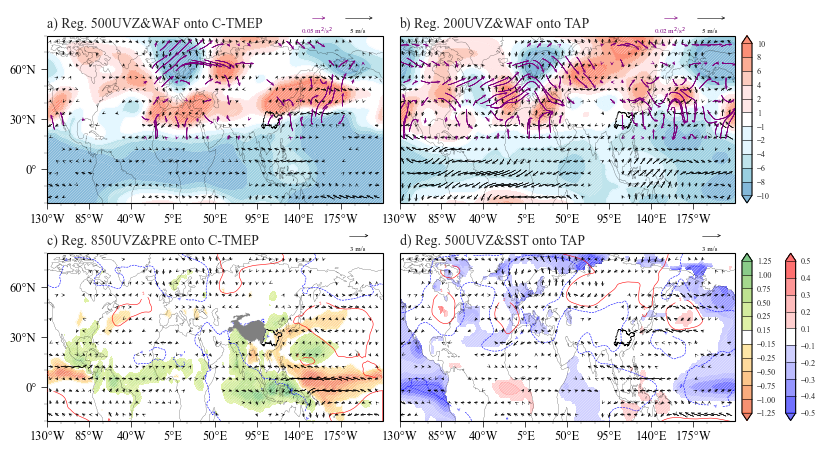

In [32]:
# type1绘图
if 1:
    fig = plt.figure(figsize=(8.88, 5))
    # fig.subplots_adjust(hspace=0.4)  # Increase vertical spacing between subplots
    # plt.subplots_adjust(wspace=0.1, hspace=0.05)
    xticks1 = np.arange(draw_zone_2[0], draw_zone_2[1], 5)
    yticks1 = np.arange(draw_zone_2[2], draw_zone_2[3], 30)
    #子图间距
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1], hspace=0.3, wspace=0.05)
    ax1 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree(central_longitude=c_lon_1))
    ax1.set_title(f"b) Reg. 200UVZ&WAF onto TAP", fontsize=10, loc='left')
    ax1.set_extent(draw_zone_1, crs=ccrs.PlateCarree())
    ax1.set_aspect('auto')
    # ax1.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax1.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.15)
    ax1.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(),
                      facecolor='none', edgecolor='black', linewidth=.5)
    # rec(ax1, zone_1, color='green')
    latlon_fmt(ax1, xticks1, None, MultipleLocator(45), MultipleLocator(15), MultipleLocator(30), MultipleLocator(10))
    # 3Dwaf
    Uc = xr.DataArray(U['u'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', U['lat'].data),
                                ('lon', U['lon'].data)])
    Vc = xr.DataArray(V['v'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', V['lat'].data),
                                ('lon', V['lon'].data)])
    Tc = xr.DataArray(T['t'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', T['lat'].data),
                                ('lon', T['lon'].data)])
    GEOa = xr.DataArray(reg_z_1[1:4, :, :],
                        coords=[('level', [150, 200, 500]),
                                ('lat', U['lat'].data),
                                ('lon', U['lon'].data)])
    waf_x, waf_y, waf_z = TN_WAF_3D(Uc, Vc, GEOa, Tc)
    reg_z_, lon = add_cyclic_point(reg_z_1[2, :, :], coord=Z['lon'])
    corr_z_, lon = add_cyclic_point(corr_z_1[2, :, :], coord=Z['lon'])
    lev_z = np.array([-10, -8, -6, -4, -2, -1, 1, 2, 4, 6, 8, 10])

    positive_values = reg_z_[reg_z_ > 0]
    q50_positive = np.round(np.percentile(positive_values, 66.6)/9.8) if positive_values.size > 0 else 0
    positive_values = reg_z_[reg_z_ < 0]
    q50_positive_ = np.round(np.percentile(positive_values, 66.6)/9.8) if positive_values.size > 0 else 0
    # z_high = ax1.contour(lon, Z['lat'], reg_z_/9.8, colors='red', levels=[q50_positive], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    # z_low = ax1.contour(lon, Z['lat'], reg_z_/9.8, colors='blue', levels=[q50_positive_], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    # z_high.clabel(inline=1, fontsize=3)
    # z_low.clabel(inline=1, fontsize=3)

    # Z
    z_cont = ax1.contour(lon, Z['lat'], reg_z_/9.8, colors='white', levels=np.array([-10, -8, -6, -4, -2, 2, 4, 6, 8, 10]), linestyles='solid', linewidths=0.2, transform=ccrs.PlateCarree(central_longitude=0))
    Z_contf = ax1.contourf(lon, Z['lat'], reg_z_/9.8, cmap=cmaps.temp_diff_18lev[5:-5], levels=lev_z, extend='both', alpha=0.75, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_z_) > p_th, 0, np.nan)
    #ax2.quiver(lon, Sst['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # 显著性
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#FFFFFF'
    p_hatches = ax1.contourf(lon, Z['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)

    wind = Curlyquiver(ax1, U['lon'], U['lat'], reg_u_1[2, :, :], reg_v_1[2, :, :], thinning=['30%', 'min'],
                                  center_lon=c_lon_1, arrowsize=.5, scale=10, linewidth=0.3, regrid=15,
                                   color='k', nanmax=20/3)
    wind.key(fig, U=5, label='5 m/s', ud=7.7, edgecolor='none', arrowsize=.5, linewidth=0.4,color='k')
    WAF_cq = Curlyquiver(ax1, waf_x['lon'], waf_x['lat'][:180],
                                  waf_x[1][:180, :], waf_y[1][:180, :], thinning=['50%', 'min'],
                                  regrid=10, center_lon=c_lon_1, arrowsize=.5, scale=3, linewidth=0.4,
                                  color='purple', nanmax=.2)
    WAF_cq.key(fig, U=.02, label='0.02 m$^2$/s$^2$', lr=1.8, ud=7.7, edgecolor='none', arrowsize=.5, linewidth=0.4)

    # 边框显示为黑色
    ax1.grid(False)
    for spine in ax1.spines.values():
        spine.set_edgecolor('black')
    # 色标
    ax1_colorbar = inset_axes(ax1, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.02, 0., 1, 1), bbox_transform=ax1.transAxes, borderpad=0)
    cb1 = plt.colorbar(Z_contf, cax=ax1_colorbar, orientation='vertical', drawedges=True)
    cb1.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    cb1.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    cb1.locator = ticker.FixedLocator(lev_z)
    # cb1.locator = ticker.FixedLocator(np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25]))
    # cb1.set_ticklabels(['-30', '-25', '-20', '-15', '-10', '-5', '5', '10', '15', '20', '25', '30'])
    cb1.ax.tick_params(length=0, labelsize=6)  # length为刻度线的长度


    ax4 = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree(central_longitude=c_lon_1))
    ax4.set_title(f"d) Reg. 500UVZ&SST onto TAP", fontsize=10, loc='left')
    ax4.set_extent(draw_zone_1, crs=ccrs.PlateCarree())
    ax4.set_aspect('auto')
    # ax4.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax4.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.15)
    ax4.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='black', linewidth=.5)
    # rec(ax4, zone_1, color='green')
    reg_z_, lon = add_cyclic_point(reg_z_1[2, :, :], coord=Z['lon'])
    corr_z_, lon = add_cyclic_point(corr_z_1[2, :, :], coord=Z['lon'])
    lev_z = np.array([-10, -8, -6, -4, -2, 2, 4, 6, 8, 10])
    latlon_fmt(ax4, xticks1, None, MultipleLocator(45), MultipleLocator(15), MultipleLocator(30), MultipleLocator(10))
    # z
    positive_values = reg_z_1[3][reg_z_1[3] > 0]
    q50_positive = np.round(np.percentile(positive_values, 33.3)/9.8) if positive_values.size > 0 else 0
    positive_values = reg_z_1[3][reg_z_1[3] < 0]
    q50_positive_ = np.round(np.percentile(positive_values, 66.6)/9.8) if positive_values.size > 0 else 0
    z_high = ax4.contour(Z['lon'], Z['lat'], reg_z_1[3, :, :]/9.8, colors='red', levels=[q50_positive], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_low = ax4.contour(Z['lon'], Z['lat'], reg_z_1[3, :, :]/9.8, colors='blue', levels=[q50_positive_], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_high.clabel(inline=1, fontsize=3)
    z_low.clabel(inline=1, fontsize=3)

    reg_sst_, lon = add_cyclic_point(reg_sst_1[:, :], coord=Sst['lon'])
    corr_sst_, lon = add_cyclic_point(corr_sst_1[:, :], coord=Sst['lon'])
    reg_sst_ = np.where((np.abs(reg_sst_) < .1), np.nan, reg_sst_)
    # sst
    sst = ax4.contourf(lon, Sst['lat'], reg_sst_, cmap=cmaps.GMT_polar[2:10] + cmaps.CBR_wet[0] + cmaps.GMT_polar[10:-2], levels=[-.5, -.4, -.3, -.2, -.1, .1, .2, .3, .4, .5], extend='both', alpha=0.75, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_sst_) > p_th, 0, np.nan)
    #ax4.quiver(lon, Sst['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # 显著性
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#FFFFFF'
    p_hatches = ax4.contourf(lon, Sst['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)


    wind = Curlyquiver(ax4, U['lon'], U['lat'], reg_u_2[3, :, :], reg_v_2[3, :, :], thinning=['40%', 'min'],
                                  center_lon=c_lon_2, arrowsize=.5, scale=9, linewidth=0.3, regrid=15,
                                  color='k', nanmax=wind.nanmax)
    wind.key(fig, U=3, label='3 m/s', ud=7.7, edgecolor='none', arrowsize=.5, color='k', linewidth=0.4)

    # 边框显示为黑色
    ax4.grid(False)
    for spine in ax4.spines.values():
        spine.set_edgecolor('black')

    # 色标
    ax4_colorbar = inset_axes(ax4, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.15, 0., 1, 1), bbox_transform=ax4.transAxes, borderpad=0)
    cb4 = plt.colorbar(sst, cax=ax4_colorbar, orientation='vertical', drawedges=True)
    cb4.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    cb4.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    # cb1.locator = ticker.FixedLocator(np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25]))
    # cb1.set_ticklabels(['-30', '-25', '-20', '-15', '-10', '-5', '5', '10', '15', '20', '25', '30'])
    cb4.ax.tick_params(length=0, labelsize=6)  # length为刻度线的长度



    ##################

    ax2 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=c_lon_2))
    ax2.set_title(f"a) Reg. 500UVZ&WAF onto C-TMEP", fontsize=10, loc='left')
    ax2.set_extent(draw_zone_2, crs=ccrs.PlateCarree())
    ax2.set_aspect('auto')
    # ax2.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax2.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.15)
    ax2.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='black', linewidth=.5)
    # rec(ax2, zone_1, color='green')
    reg_z_, lon = add_cyclic_point(reg_z_2[2, :, :], coord=Z['lon'])
    corr_z_, lon = add_cyclic_point(corr_z_2[2, :, :], coord=Z['lon'])
    lev_z = np.array([-10, -8, -6, -4, -2, 2, 4, 6, 8, 10])
    latlon_fmt(ax2, xticks1, yticks1, MultipleLocator(45), MultipleLocator(15), MultipleLocator(30), MultipleLocator(10))
    # # z
    # positive_values = reg_z_2[3][reg_z_2[3] > 0]
    # q50_positive = np.round(np.percentile(positive_values, 33.3)/9.8) if positive_values.size > 0 else 0
    # positive_values = reg_z_2[3][reg_z_2[3] < 0]
    # q50_positive_ = np.round(np.percentile(positive_values, 66.6)/9.8) if positive_values.size > 0 else 0
    # z_high = ax2.contour(Z['lon'], Z['lat'], reg_z_[3, :, :]/9.8, colors='red', levels=[q50_positive], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    # z_low = ax2.contour(Z['lon'], Z['lat'], reg_z_[3, :, :]/9.8, colors='blue', levels=[q50_positive_], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    # z_high.clabel(inline=1, fontsize=3)
    # z_low.clabel(inline=1, fontsize=3)

    # Z
    z_cont = ax2.contour(lon, Z['lat'], reg_z_/9.8, colors='white', levels=lev_z, linestyles='solid', linewidths=0.2, transform=ccrs.PlateCarree(central_longitude=0))
    Z_contf = ax2.contourf(lon, Z['lat'], reg_z_/9.8, cmap=cmaps.temp_diff_18lev[5:-5], levels=lev_z, extend='both', alpha=0.75, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_z_) > p_th, 0, np.nan)
    #ax2.quiver(lon, Sst['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # 显著性
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#FFFFFF'
    p_hatches = ax2.contourf(lon, Z['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)

    # reg_sst_, lon = add_cyclic_point(reg_sst_2[:, :], coord=Sst['lon'])
    # corr_sst_, lon = add_cyclic_point(corr_sst_2[:, :], coord=Sst['lon'])
    # reg_sst_ = np.where((np.abs(reg_sst_) < .1), np.nan, reg_sst_)
    # # sst
    # sst = ax2.contourf(lon, Sst['lat'], reg_sst_, cmap=cmaps.GMT_polar[2:10] + cmaps.CBR_wet[0] + cmaps.GMT_polar[10:-2], levels=[-.5, -.4, -.3, -.2, -.1, .1, .2, .3, .4, .5], extend='both', alpha=0.75, transform=ccrs.PlateCarree(central_longitude=0))
    # p_test = np.where(np.abs(corr_sst_) > p_th, 0, np.nan)
    # #ax2.quiver(lon, Sst['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # # 显著性
    # plt.rcParams['hatch.linewidth'] = 0.2
    # plt.rcParams['hatch.color'] = '#FFFFFF'
    # p_hatches = ax2.contourf(lon, Sst['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)

    # wind
    GEOa2 = xr.DataArray(reg_z_2[1:4, :, :],
                        coords=[('level', [150, 200, 500]),
                                ('lat', U['lat'].data),
                                ('lon', U['lon'].data)])
    waf_x, waf_y, waf_z = TN_WAF_3D(Uc, Vc, GEOa2, Tc)

    wind = Curlyquiver(ax2, U['lon'], U['lat'], reg_u_2[3, :, :], reg_v_2[3, :, :], thinning=['40%', 'min'],
                                  center_lon=c_lon_2, arrowsize=.5, scale=10, linewidth=0.3, regrid=15,
                                  color='k', nanmax=wind.nanmax)
    wind.key(fig, U=5, label='5 m/s', ud=7.7, edgecolor='none', arrowsize=.5, color='k', linewidth=0.4)
    WAF_cq = Curlyquiver(ax2, waf_x['lon'], waf_x['lat'][:180],
                                  waf_x[2][:180, :], waf_y[2][:180, :], thinning=['75%', 'min'],
                                  regrid=10, center_lon=c_lon_2, arrowsize=.5, scale=7.5, linewidth=0.4,
                                  color='purple', nanmax=.2)
    WAF_cq.key(fig, U=.05, label='0.05 m$^2$/s$^2$', lr=1.8, ud=7.7, edgecolor='none', arrowsize=.5, linewidth=0.4)
    # 边框显示为黑色
    ax2.grid(False)
    for spine in ax2.spines.values():
        spine.set_edgecolor('black')

    # # 色标
    # ax2_colorbar = inset_axes(ax2, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.02, 0., 1, 1), bbox_transform=ax2.transAxes, borderpad=0)
    # cb2 = plt.colorbar(Z_contf, cax=ax2_colorbar, orientation='vertical', drawedges=True)
    # cb2.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    # cb2.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    # # cb1.locator = ticker.FixedLocator(np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25]))
    # # cb1.set_ticklabels(['-30', '-25', '-20', '-15', '-10', '-5', '5', '10', '15', '20', '25', '30'])
    # cb2.ax.tick_params(length=0, labelsize=6)  # length为刻度线的长度


    ax3 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree(central_longitude=c_lon_2))
    ax3.set_title(f"c) Reg. 850UVZ&PRE onto C-TMEP", fontsize=10, loc='left')
    ax3.set_extent(draw_zone_2, crs=ccrs.PlateCarree())
    ax3.set_aspect('auto')
    # ax3.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax3.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.15)
    ax3.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='black', linewidth=.5)
    # rec(ax3, zone_2, color='green')
    ax3.add_geometries(Reader(r'D:\PyFile\map\地图边界数据\青藏高原边界数据总集\TPBoundary_2500m\TPBoundary_2500m.shp').geometries(),
                                   ccrs.PlateCarree(), facecolor='gray', edgecolor='gray', linewidth=.1, hatch='.', zorder=10)
    latlon_fmt(ax3, xticks1, yticks1, MultipleLocator(45), MultipleLocator(15), MultipleLocator(30), MultipleLocator(10))
    reg_pre_, lon = add_cyclic_point(reg_pre_2[:, :], coord=Pre['lon'])
    corr_pre_, lon = add_cyclic_point(corr_pre_2[:, :], coord=Pre['lon'])

    #pre
    reg_pre_, lon = add_cyclic_point(reg_pre_2[:, :], coord=Pre['lon'])
    corr_pre_, lon = add_cyclic_point(corr_pre_2[:, :], coord=Pre['lon'])

    # pre
    pre = ax3.contourf(lon, Pre['lat'], reg_pre_, cmap=cmaps.MPL_RdYlGn[22+0:56] + cmaps.CBR_wet[0] + cmaps.MPL_RdYlGn[72:106-0], alpha=0.75, levels=[-1.25, -1., -.75, -.5, -.25, -.15, .15, .25, .5, .75, 1., 1.25], extend='both', transform=ccrs.PlateCarree(central_longitude=0))
    pre_edge = ax3.contour(lon, Pre['lat'], reg_pre_, colors='white', levels=[-1.25, -1., -.75, -.5, -.25, .25, .5, .75, 1., 1.25], linestyles='solid',linewidths=0.2, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_pre_) > p_th, 0, np.nan)
    #ax3.quiver(lon, Pre['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # 显著性
    p_hatches = ax3.contourf(lon, Pre['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#FFFFFF'
    # wind
    wind = Curlyquiver(ax3, U['lon'], U['lat'], reg_u_2[4, :, :], reg_v_2[4, :, :], thinning=[0.2, 'min'],
                                  center_lon=c_lon_2, arrowsize=.5, scale=9, linewidth=0.3, regrid=15,
                                color='k', nanmax=wind.nanmax)
    wind.key(fig, U=3, label='3 m/s', ud=7.7, edgecolor='none', arrowsize=.5, color='k', linewidth=0.4)
    # z
    positive_values = reg_z_2[4][reg_z_2[4] > 0]
    q50_positive = np.round(np.percentile(positive_values, 33.3)/9.8) if positive_values.size > 0 else 0
    positive_values = reg_z_2[4][reg_z_2[4] < 0]
    q50_positive_ = np.round(np.percentile(positive_values, 40)/9.8) if positive_values.size > 0 else 0
    z_high = ax3.contour(Z['lon'], Z['lat'], reg_z_2[4, :, :]/9.8, colors='red', levels=[q50_positive], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_low = ax3.contour(Z['lon'], Z['lat'], reg_z_2[4, :, :]/9.8, colors='blue', levels=[q50_positive_], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_high.clabel(inline=1, fontsize=3)
    z_low.clabel(inline=1, fontsize=3)
    # 边框显示为黑色
    ax3.grid(False)
    for spine in ax3.spines.values():
        spine.set_edgecolor('black')
    # 色条
    ax3_colorbar = inset_axes(ax3, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.02, 0., 1, 1), bbox_transform=ax4.transAxes, borderpad=0)
    cb3 = plt.colorbar(pre, cax=ax3_colorbar, orientation='vertical', drawedges=True)
    cb3.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    cb3.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    cb3.locator = ticker.FixedLocator(np.array([-1.25, -1., -.75, -.5, -.25, -.15, .15, .25, .5, .75, 1., 1.25]))
    #cb3.set_ticklabels(['-0.5', '-0.4', '-0.3', '-0.2', '-0.1', '0.1', '0.2', '0.3', '0.4', '0.5'])
    cb3.ax.tick_params(length=0, labelsize=6)  # length为刻度线的长度


    plt.savefig(f'D:/PyFile/p2/pic/回归场1.png', dpi=600, bbox_inches='tight')
    plt.show()


C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)
C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'add_colorbar', 'edgecolor'
  result = super().contourf(*args, **kwargs)
D:\Code\work\Meteorological\toolbar\curved_quivers\modplot.py:303: UserWarning: 已将Y轴反转，因为Y轴坐标轴为非增长序列。
  warnings.warn('已将Y轴反转，因为Y轴坐标轴为非增长序列。', UserWarning)
路径积分: 100%|██████████| 700/700 [00:02<00:00, 244.12points/s]
D:\Code\work\Meteorological\toolbar\curved_quivers\modplot.py:303: UserWarning: 已将Y轴反转，因为Y轴坐标轴为非增长序列。
  warnings.warn('已将Y轴反转，因为Y轴坐标轴为非增长序列。', UserWarning)
D:\Code\work\Meteorological\toolbar\curved_quivers\modplot.py:388: UserWarning: 高纬地区数据缺测，已进行延拓(fill np.nan)
  warnings.warn('高纬地区数据缺测，已进行延拓(fill np.nan)', UserWarning)
D:\Code\work\Meteorological\toolbar\curved_quivers\modpl

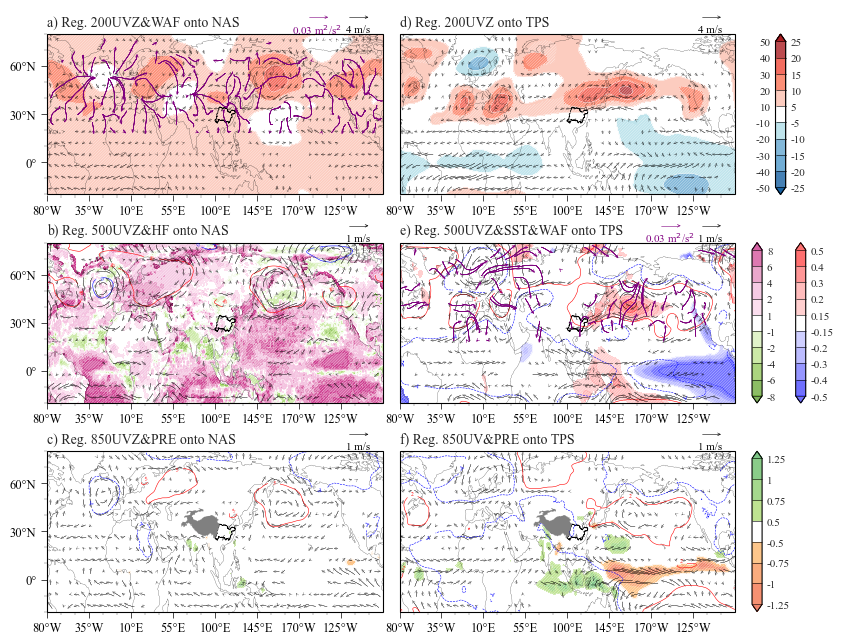

In [48]:
# type2绘图
if 2:
    fig = plt.figure(figsize=(8.88, 7.5))
    fig.subplots_adjust(hspace=0.4)  # Increase vertical spacing between subplots
    xticks1 = np.arange(draw_zone_1[0], draw_zone_1[1], 5)
    yticks1 = np.arange(draw_zone_1[2], draw_zone_1[3], 30)
    #子图间距
    gs = gridspec.GridSpec(3, 2, width_ratios=[1, 1], height_ratios=[1, 1, 1], hspace=0.3, wspace=0.05)
    plt.subplots_adjust(wspace=0.1, hspace=0.05)
    ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=c_lon_1))
    ax1.set_title(f"a) Reg. 200UVZ&WAF onto NAS", fontsize=10, loc='left')
    ax1.set_extent(draw_zone_1, crs=ccrs.PlateCarree())
    ax1.set_aspect('auto')
    ax1.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.15)
    # ax1.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax1.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(),
                      facecolor='none', edgecolor='black', linewidth=.5)
    # rec(ax1, zone_1, color='green')
    latlon_fmt(ax1, xticks1, yticks1, MultipleLocator(45), MultipleLocator(15), MultipleLocator(30), MultipleLocator(10))
    # 3Dwaf
    Uc = xr.DataArray(U['u'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', U['lat'].data),
                                ('lon', U['lon'].data)])
    Vc = xr.DataArray(V['v'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', V['lat'].data),
                                ('lon', V['lon'].data)])
    Tc = xr.DataArray(T['t'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', T['lat'].data),
                                ('lon', T['lon'].data)])
    GEOa = xr.DataArray(reg_z_1[1:4, :, :],
                        coords=[('level', [150, 200, 500]),
                                ('lat', U['lat'].data),
                                ('lon', U['lon'].data)])
    waf_x, waf_y, waf_z = TN_WAF_3D(Uc, Vc, GEOa, Tc)
    reg_z_, lon = add_cyclic_point(reg_z_1[2, :, :], coord=Z['lon'])
    corr_z_, lon = add_cyclic_point(corr_z_1[2, :, :], coord=Z['lon'])
    # reg_z_ = np.where((np.abs(reg_z_/9.8) < 15), np.nan, reg_z_)
    waf_contf_ = ax1.contourf(lon, Z['lat'], reg_z_/9.8,
                                           levels=np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25])*2,
                                           cmap=cmaps.temp_diff_18lev[2:-2], alpha=0.75,
                                           extend='both',
                                           transform=ccrs.PlateCarree(central_longitude=0))
    waf_cont = ax1.contour(lon, Z['lat'], reg_z_/9.8, colors='white', levels=np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25])*2, linestyles='solid', linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_z_) > p_th, 0, np.nan)

    # 显著性
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#FFFFFF'
    p_hatches = ax1.contourf(lon, Z['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)

    # # z
    # positive_values = reg_z_1[2][reg_z_1[2] > 0]
    # q50_positive = np.round(np.percentile(positive_values, 90)/9.8) if positive_values.size > 0 else 0
    # positive_values = reg_z_1[2][reg_z_1[2] < 0]
    # q50_positive_ = np.round(np.percentile(positive_values, 66.6)/9.8) if positive_values.size > 0 else 0
    # z_high = ax1.contour(lon, Z['lat'], reg_z_/9.8, colors='red', levels=[q50_positive], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    # z_low = ax1.contour(lon, Z['lat'], reg_z_/9.8, colors='blue', levels=[q50_positive_], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    # z_high.clabel(inline=1, fontsize=3)
    # z_low.clabel(inline=1, fontsize=3)
    # waf_contf = ax1.contourf(lon, Z['lat'], reg_z_/9.8,
    #                                        levels=np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25]),
    #                                        cmap=cmaps.temp_diff_18lev[2:-2], alpha=0.75,
    #                                        extend='both',
    #                                        transform=ccrs.PlateCarree(central_longitude=0))
    # waf_cont = ax1.contour(lon, Z['lat'], reg_z_/9.8, colors='white', levels=np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25]), linestyles='solid', linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    # p_test = np.where(np.abs(corr_z_) > p_th, 0, np.nan)
    # #ax1.quiver(lon, Z['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # # 显著性
    # plt.rcParams['hatch.linewidth'] = 0.2
    # plt.rcParams['hatch.color'] = '#FFFFFF'
    # p_hatches = ax1.contourf(lon, Z['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)
    wind = Curlyquiver(ax1, U['lon'], U['lat'], reg_u_1[2, :, :], reg_v_1[2, :, :], thinning=["40%", 'min'],
                                  center_lon=c_lon_1, arrowsize=.5, scale=12, linewidth=0.15, regrid=15,
                                   color='k', nanmax=20/3, MinDistance=[0.2, 0.1])
    wind.key(fig, U=4, label='4 m/s', ud=7.7, edgecolor='none', arrowsize=.5, linewidth=0.4,color='k', fontproperties={'size': 8})
    WAF_cq = Curlyquiver(ax1, waf_x['lon'], waf_x['lat'][:180],
                                  waf_x[1][:180, :], waf_y[1][:180, :], thinning=['50%', 'min'],
                                  regrid=10, center_lon=c_lon_1, arrowsize=.5, scale=3, linewidth=0.4,
                                  color='purple', nanmax=.2, MinDistance=[0.2, 0.1], regrid_reso=2.5)
    WAF_cq.key(fig, U=.03, label='0.03 m$^2$/s$^2$', lr=1.8, ud=7.7, edgecolor='none', arrowsize=.5, linewidth=0.4, fontproperties={'size': 8})
    # 边框显示为黑色
    ax1.grid(False)
    for spine in ax1.spines.values():
        spine.set_edgecolor('black')

    ax2 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree(central_longitude=c_lon_1))
    ax2.set_title(f"b) Reg. 500UVZ&HF onto NAS", fontsize=10, loc='left')
    ax2.set_extent(draw_zone_1, crs=ccrs.PlateCarree())
    ax2.set_aspect('auto')
    # ax2.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax2.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.15)
    ax2.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='black', linewidth=.5)
    # rec(ax2, zone_1, color='green')
    latlon_fmt(ax2, xticks1, yticks1, MultipleLocator(45), MultipleLocator(15), MultipleLocator(30), MultipleLocator(10))
    # z
    positive_values = reg_z_2[3][reg_z_2[3] > 0]
    q50_positive = np.round(np.percentile(positive_values, 90)/9.8) if positive_values.size > 0 else 0
    positive_values = reg_z_2[3][reg_z_2[3] < 0]
    q50_positive_ = np.round(np.percentile(positive_values, 95)/9.8) if positive_values.size > 0 else 0
    z_high = ax2.contour(Z['lon'], Z['lat'], reg_z_1[3, :, :]/9.8, colors='red', levels=[q50_positive], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_low = ax2.contour(Z['lon'], Z['lat'], reg_z_1[3, :, :]/9.8, colors='blue', levels=[q50_positive_], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_high.clabel(inline=1, fontsize=4)
    z_low.clabel(inline=1, fontsize=4)
    reg_radio_, lon = add_cyclic_point(reg_radio_1[:, :], coord=surface_radio['lon'])##########################
    corr_radio_, lon = add_cyclic_point(corr_radio_1[:, :], coord=surface_radio['lon'])##########################
    # reg_sst_ = np.where((np.abs(reg_sst_) < .15), np.nan, reg_sst_)
    # sst
    surf_con = ax2.contourf(lon, surface_radio['lat'], reg_radio_, cmap=cmaps.MPL_PiYG_r[15:64-10] + cmaps.CBR_wet[0] + cmaps.MPL_PiYG_r[-64+10:-15], levels=np.array([-8, -6, -4, -2, -1, 1, 2, 4, 6, 8]), extend='both', alpha=0.75, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none')
    p_test = np.where(np.abs(corr_radio_) > p_th, 0, np.nan)
    #ax2.quiver(lon, Sst['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # 显著性
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#FFFFFF'
    p_hatches = ax2.contourf(lon, surface_radio['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)
    # wind
    wind = Curlyquiver(ax2, U['lon'], U['lat'], reg_u_1[3, :, :], reg_v_1[3, :, :], thinning=["40%", 'min'],
                                  center_lon=c_lon_1, arrowsize=.5, scale=3, linewidth=0.15, regrid=15,
                                  color='k', nanmax=wind.nanmax, MinDistance=[0.2, 0.1])
    wind.key(fig, U=1, label='1 m/s', ud=7.7, edgecolor='none', arrowsize=.5, color='k', linewidth=0.4, fontproperties={'size': 8})
    # 边框显示为黑色
    ax2.grid(False)
    for spine in ax2.spines.values():
        spine.set_edgecolor('black')

    ax3 = fig.add_subplot(gs[2, 0], projection=ccrs.PlateCarree(central_longitude=c_lon_1))
    ax3.set_title(f"c) Reg. 850UVZ&PRE onto NAS", fontsize=10, loc='left')
    ax3.set_extent(draw_zone_1, crs=ccrs.PlateCarree())
    ax3.set_aspect('auto')
    # ax3.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax3.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.15)
    ax3.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='black', linewidth=.5)
    # rec(ax3, zone_1, color='green')
    ax3.add_geometries(Reader(r'D:\PyFile\map\地图边界数据\青藏高原边界数据总集\TPBoundary_2500m\TPBoundary_2500m.shp').geometries(),
                                   ccrs.PlateCarree(), facecolor='gray', edgecolor='gray', linewidth=.1, hatch='.', zorder=10)
    latlon_fmt(ax3, xticks1, yticks1, MultipleLocator(45), MultipleLocator(15), MultipleLocator(30), MultipleLocator(10))

    reg_pre_da = xr.DataArray(reg_pre_1, coords=[Pre['lat'], Pre['lon']], dims=['lat', 'lon'])
    reg_pre_da = reg_pre_da.interp(
        lat=np.arange(-90, 90, 0.25),
        lon=np.arange(0, 360, 0.25),
        method='linear',
        kwargs={'fill_value': "extrapolate"}
    )

    reg_pre_, reg_pre_da_lon = add_cyclic_point(reg_pre_da.values, coord=reg_pre_da['lon'])
    corr_pre_, lon = add_cyclic_point(corr_pre_1[:, :], coord=Pre['lon'])
    # reg_pre_ = np.where((np.abs(reg_pre_) < .5), np.nan, reg_pre_)
    # pre
    pre = ax3.contourf(reg_pre_da_lon, reg_pre_da['lat'], reg_pre_, cmap=cmaps.MPL_RdYlGn[22+0:56] + cmaps.CBR_wet[0] + cmaps.MPL_RdYlGn[72:106-0], alpha=0.75, levels=[-1.25, -1., -.75, -.5, .5, .75, 1., 1.25], extend='both', transform=ccrs.PlateCarree(central_longitude=0))
    pre_edge = ax3.contour(reg_pre_da_lon, reg_pre_da['lat'], reg_pre_, colors='white', levels=[-1.25, -1., -.75, -.5, .5, .75, 1., 1.25], linestyles='solid',linewidths=0.2, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_pre_) > p_th, 0, np.nan)
    #ax3.quiver(lon, Pre['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # 显著性
    p_hatches = ax3.contourf(lon, Pre['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#FFFFFF'
    # wind
    wind = Curlyquiver(ax3, U['lon'], U['lat'], reg_u_1[4, :, :], reg_v_1[4, :, :], thinning=["40%", 'min'],
                                  center_lon=c_lon_1, arrowsize=.5, scale=3, linewidth=0.15, regrid=15,
                                color='k', nanmax=wind.nanmax, MinDistance=[0.2, 0.1])
    wind.key(fig, U=1, label='1 m/s', ud=7.7, edgecolor='none', arrowsize=.5, color='k', linewidth=0.4, fontproperties={'size': 8})
    # z
    positive_values = reg_z_2[4][reg_z_2[4] > 0]
    q50_positive = np.round(np.percentile(positive_values, 70)/9.8) if positive_values.size > 0 else 0
    positive_values = reg_z_2[4][reg_z_2[4] < 0]
    q50_positive_ = np.round(np.percentile(positive_values, 66.6)/9.8) if positive_values.size > 0 else 0
    z_high = ax3.contour(Z['lon'], Z['lat'], reg_z_1[4, :, :]/9.8, colors='red', levels=[q50_positive], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_low = ax3.contour(Z['lon'], Z['lat'], reg_z_1[4, :, :]/9.8, colors='blue', levels=[q50_positive_], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_high.clabel(inline=1, fontsize=4)
    z_low.clabel(inline=1, fontsize=4)
    # 边框显示为黑色
    ax3.grid(False)
    for spine in ax3.spines.values():
        spine.set_edgecolor('black')

    ax4, ax5, ax6 = ax1, ax2, ax3

    ################################################################右图
    xticks1 = np.arange(draw_zone_2[0], draw_zone_2[1], 5)
    yticks1 = np.arange(draw_zone_2[2], draw_zone_2[3], 30)
    ax1 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree(central_longitude=c_lon_2))
    ax1.set_title(f"d) Reg. 200UVZ onto TPS", fontsize=10, loc='left')
    ax1.set_extent(draw_zone_2, crs=ccrs.PlateCarree())
    ax1.set_aspect('auto')
    # ax1.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax1.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.15)
    ax1.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(),
                      facecolor='none', edgecolor='black', linewidth=.5)
    # rec(ax1, zone_2, color='green')
    latlon_fmt(ax1, xticks1, None, MultipleLocator(45), MultipleLocator(15), MultipleLocator(30), MultipleLocator(10))
    # 3Dwaf
    Uc = xr.DataArray(U['u'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', U['lat'].data),
                                ('lon', U['lon'].data)])
    Vc = xr.DataArray(V['v'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', V['lat'].data),
                                ('lon', V['lon'].data)])
    Tc = xr.DataArray(T['t'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', T['lat'].data),
                                ('lon', T['lon'].data)])
    GEOa = xr.DataArray(reg_z_2[1:4, :, :],
                        coords=[('level', [150, 200, 500]),
                                ('lat', U['lat'].data),
                                ('lon', U['lon'].data)])
    waf_x, waf_y, waf_z = TN_WAF_3D(Uc, Vc, GEOa, Tc)
    reg_z_, lon = add_cyclic_point(reg_z_2[2, :, :], coord=Z['lon'])
    corr_z_, lon = add_cyclic_point(corr_z_2[2, :, :], coord=Z['lon'])
    # reg_z_ = np.where((np.abs(reg_z_/9.8) < 5), np.nan, reg_z_)
    waf_contf = ax1.contourf(lon, Z['lat'], reg_z_/9.8,
                                           levels=np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25]),
                                           cmap=cmaps.temp_diff_18lev[2:-2], alpha=0.75,
                                           extend='both',
                                           transform=ccrs.PlateCarree(central_longitude=0))
    waf_cont = ax1.contour(lon, Z['lat'], reg_z_/9.8, colors='white', levels=np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25]), linestyles='solid', linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_z_) > p_th, 0, np.nan)
    #ax1.quiver(lon, Z['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # 显著性
    p_hatches = ax1.contourf(lon, Z['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#FFFFFF'

    wind = Curlyquiver(ax1, U['lon'], U['lat'], reg_u_2[2, :, :], reg_v_2[2, :, :], thinning=["40%", 'min'],
                                  center_lon=c_lon_2, arrowsize=.5, scale=12, linewidth=0.15, regrid=15,
                                   color='k', nanmax=wind.nanmax, MinDistance=[0.2, 0.1])
    wind.key(fig, U=4, label='4 m/s', ud=7.7, edgecolor='none', arrowsize=.5, color='k', linewidth=0.4, fontproperties={'size': 8})
    # 边框显示为黑色
    ax1.grid(False)
    for spine in ax1.spines.values():
        spine.set_edgecolor('black')
    # 色标
    ax1_colorbar = inset_axes(ax1, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.12, 0., 1, 1), bbox_transform=ax1.transAxes, borderpad=0)
    cb1 = plt.colorbar(waf_contf, cax=ax1_colorbar, orientation='vertical', drawedges=True)
    cb1.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    cb1.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    cb1.locator = ticker.FixedLocator(np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25]))
    cb1.set_ticklabels(['-25', '-20', '-15', '-10', '-5', '5', '10', '15', '20', '25'])
    cb1.ax.yaxis.set_ticks_position('right')
    cb1.ax.yaxis.set_label_position('right')
    # cb1.ax.set_ylabel('Right\npic', rotation=0, loc='bottom', fontsize=6)
    cb1.ax.tick_params(length=0, labelsize=8)  # length为刻度线的长度

        # 色标
    ax4_colorbar = inset_axes(ax4, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.12, 0., 1, 1), bbox_transform=ax1.transAxes, borderpad=0)
    cb4 = plt.colorbar(waf_contf_, cax=ax4_colorbar, orientation='vertical', drawedges=True)
    cb4.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    cb4.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    cb4.locator = ticker.FixedLocator(np.array([-50, -40, -30, -20, -10, 10, 20, 30, 40, 50]))
    cb4.set_ticklabels(['-50', '-40', '-30', '-20', '-10', '10', '20', '30', '40', '50'])
    cb4.ax.yaxis.set_ticks_position('left')
    cb4.ax.yaxis.set_label_position('left')
    # cb4.ax.set_ylabel('Left\npic', rotation=0, loc='bottom', fontsize=6)
    cb4.ax.tick_params(length=0, labelsize=8)  # length为刻度线的长度

    ax2 = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree(central_longitude=c_lon_2))
    ax2.set_title(f"e) Reg. 500UVZ&SST&WAF onto TPS", fontsize=10, loc='left')
    ax2.set_extent(draw_zone_2, crs=ccrs.PlateCarree())
    ax2.set_aspect('auto')
    # ax2.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax2.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.15)
    ax2.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='black', linewidth=.5)
    # rec(ax2, zone_2, color='green')
    latlon_fmt(ax2, xticks1, None, MultipleLocator(45), MultipleLocator(15), MultipleLocator(30), MultipleLocator(10))
    # z
    positive_values = reg_z_2[3][reg_z_2[3] > 0]
    q50_positive = np.round(np.percentile(positive_values, 33.3)/9.8) if positive_values.size > 0 else 0
    positive_values = reg_z_2[3][reg_z_2[3] < 0]
    q50_positive_ = np.round(np.percentile(positive_values, 66.6)/9.8) if positive_values.size > 0 else 0
    z_high = ax2.contour(Z['lon'], Z['lat'], reg_z_2[3, :, :]/9.8, colors='red', levels=[q50_positive], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_low = ax2.contour(Z['lon'], Z['lat'], reg_z_2[3, :, :]/9.8, colors='blue', levels=[q50_positive_], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_high.clabel(inline=1, fontsize=4)
    z_low.clabel(inline=1, fontsize=4)
    reg_sst_, lon = add_cyclic_point(reg_sst_2[:, :], coord=Sst['lon'])
    corr_sst_, lon = add_cyclic_point(corr_sst_2[:, :], coord=Sst['lon'])
    # reg_sst_ = np.where((np.abs(reg_sst_) < .15) | np.isnan(reg_sst_), np.nan, reg_sst_)
    # sst
    sst = ax2.contourf(lon, Sst['lat'], reg_sst_, cmap=cmaps.GMT_polar[2:10] + cmaps.CBR_wet[0] + cmaps.GMT_polar[10:-2], levels=[-.5, -.4, -.3, -.2, -.15, .15, .2, .3, .4, .5], extend='both', alpha=0.75, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_sst_) > p_th, 0, np.nan)
    #ax2.quiver(lon, Sst['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # 显著性
    p_hatches = ax2.contourf(lon, Sst['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#FFFFFF'
    # wind
    wind = Curlyquiver(ax2, U['lon'], U['lat'], reg_u_2[3, :, :], reg_v_2[3, :, :], thinning=["40%", 'min'],
                                  center_lon=c_lon_2, arrowsize=.5, scale=3, linewidth=0.15, regrid=15,
                                  color='k', nanmax=wind.nanmax, MinDistance=[0.2, 0.1])
    wind.key(fig, U=1, label='1 m/s', ud=7.7, edgecolor='none', arrowsize=.5, color='k', linewidth=0.4, fontproperties={'size': 8})
    WAF_cq = Curlyquiver(ax2, waf_x['lon'], waf_x['lat'][:180], waf_x[2][:180, :], waf_y[2][:180, :], thinning=['75%', 'min'], regrid=10, center_lon=c_lon_2, arrowsize=.5, scale=3, linewidth=0.4, color='purple', nanmax=.2, MinDistance=[0.2, 0.1], regrid_reso=2.5)
    WAF_cq.key(fig, U=.03, label='0.03 m$^2$/s$^2$', lr=1.8, ud=7.7, edgecolor='none', arrowsize=.5, linewidth=0.4, fontproperties={'size': 8})
    # 边框显示为黑色
    ax2.grid(False)
    for spine in ax2.spines.values():
        spine.set_edgecolor('black')
    # 色条
    ax2_colorbar = inset_axes(ax2, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.18, 0., 1, 1), bbox_transform=ax2.transAxes, borderpad=0)
    cb2 = plt.colorbar(sst, cax=ax2_colorbar, orientation='vertical', drawedges=True)
    cb2.locator = ticker.FixedLocator(np.array([-.5, -.4, -.3, -.2,-.15, .15,.2,.3,.4,.5]))
    cb2.set_ticklabels(['-0.5', '-0.4', '-0.3', '-0.2', '-0.15', '0.15', '0.2', '0.3', '0.4', '0.5'])
    cb2.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    cb2.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    cb2.ax.tick_params(length=0, labelsize=8)  # length为刻度线的长度

    # 色条
    ax5_colorbar = inset_axes(ax5, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax2.transAxes, borderpad=0)
    cb5 = plt.colorbar(surf_con, cax=ax5_colorbar, orientation='vertical', drawedges=True)
    cb5.locator = ticker.FixedLocator(np.array([-8, -6, -4, -2, -1, 1, 2, 4, 6, 8]))
    cb5.set_ticklabels(['-8', '-6', '-4', '-2', '-1', '1', '2', '4', '6', '8'])
    cb5.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    cb5.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    cb5.ax.tick_params(length=0, labelsize=8)  # length为刻度线的长度

    ax3 = fig.add_subplot(gs[2, 1], projection=ccrs.PlateCarree(central_longitude=c_lon_2))
    ax3.set_title(f"f) Reg. 850UV&PRE onto TPS", fontsize=10, loc='left')
    ax3.set_extent(draw_zone_2, crs=ccrs.PlateCarree())
    ax3.set_aspect('auto')
    # ax3.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax3.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.15)
    ax3.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='black', linewidth=.5)
    # rec(ax3, zone_2, color='green')
    ax3.add_geometries(Reader(r'D:\PyFile\map\地图边界数据\青藏高原边界数据总集\TPBoundary_2500m\TPBoundary_2500m.shp').geometries(),
                                   ccrs.PlateCarree(), facecolor='gray', edgecolor='gray', linewidth=.1, hatch='.', zorder=10)
    latlon_fmt(ax3, xticks1, None, MultipleLocator(45), MultipleLocator(15), MultipleLocator(30), MultipleLocator(10))

    reg_pre_da = xr.DataArray(reg_pre_2, coords=[Pre['lat'], Pre['lon']], dims=['lat', 'lon'])
    reg_pre_da = reg_pre_da.interp(
        lat=np.arange(-90, 90, 0.25),
        lon=np.arange(0, 360, 0.25),
        method='linear',
        kwargs={'fill_value': "extrapolate"}
    )

    reg_pre_, reg_pre_da_lon = add_cyclic_point(reg_pre_da.values, coord=reg_pre_da['lon'])
    corr_pre_, lon = add_cyclic_point(corr_pre_2[:, :], coord=Pre['lon'])
    # reg_pre_ = np.where((np.abs(reg_pre_) < .5), np.nan, reg_pre_)
    # pre
    pre = ax3.contourf(reg_pre_da_lon, reg_pre_da['lat'], reg_pre_, cmap=cmaps.MPL_RdYlGn[22+0:56] + cmaps.CBR_wet[0] + cmaps.MPL_RdYlGn[72:106-0], alpha=0.75, levels=[-1.25, -1., -.75, -.5, .5, .75, 1., 1.25], extend='both', transform=ccrs.PlateCarree(central_longitude=0))
    pre_edge = ax3.contour(reg_pre_da_lon, reg_pre_da['lat'], reg_pre_, colors='white', levels=[-1.25, -1., -.75, -.5, .5, .75, 1., 1.25], linestyles='solid',linewidths=0.2, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_pre_) > p_th, 0, np.nan)
    #ax3.quiver(lon, Pre['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # 显著性
    p_hatches = ax3.contourf(lon, Pre['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#FFFFFF'
    # wind
    wind = Curlyquiver(ax3, U['lon'], U['lat'], reg_u_2[4, :, :], reg_v_2[4, :, :], thinning=["40%", 'min'],
                                  center_lon=c_lon_2, arrowsize=.5, scale=3, linewidth=0.15, regrid=15,
                                color='k', nanmax=wind.nanmax, MinDistance=[0.2, 0.1])
    wind.key(fig, U=1, label='1 m/s', ud=7.7, edgecolor='none', arrowsize=.5, color='k', linewidth=0.4, fontproperties={'size': 8})
    # z
    positive_values = reg_z_2[4][reg_z_2[4] > 0]
    q50_positive = np.round(np.percentile(positive_values, 33.3)/9.8) if positive_values.size > 0 else 0
    positive_values = reg_z_2[4][reg_z_2[4] < 0]
    q50_positive_ = np.round(np.percentile(positive_values, 66.6)/9.8) if positive_values.size > 0 else 0
    z_high = ax3.contour(Z['lon'], Z['lat'], reg_z_2[4, :, :]/9.8, colors='red', levels=[q50_positive], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_low = ax3.contour(Z['lon'], Z['lat'], reg_z_2[4, :, :]/9.8, colors='blue', levels=[q50_positive_], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_high.clabel(inline=1, fontsize=4)
    z_low.clabel(inline=1, fontsize=4)
    # 边框显示为黑色
    ax3.grid(False)
    for spine in ax3.spines.values():
        spine.set_edgecolor('black')
    # 色条
    ax3_colorbar = inset_axes(ax3, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax3.transAxes, borderpad=0)
    cb3 = plt.colorbar(pre, cax=ax3_colorbar, orientation='vertical', drawedges=True)
    cb3.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    cb3.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    cb3.locator = ticker.FixedLocator(np.array([-1.25, -1., -.75, -.5, .5, .75, 1., 1.25]))
    cb3.set_ticklabels(['-1.25', '-1', '-0.75', '-0.5', '0.5', '0.75', '1', '1.25'])
    cb3.ax.tick_params(length=0, labelsize=8)  # length为刻度线的长度


    plt.savefig(f'D:/PyFile/p2/pic/回归场2.png', dpi=600, bbox_inches='tight')
    plt.show()


C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)
C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'add_colorbar', 'edgecolor'
  result = super().contourf(*args, **kwargs)
D:\Code\work\Meteorological\toolbar\curved_quivers\modplot.py:303: UserWarning: 已将Y轴反转，因为Y轴坐标轴为非增长序列。
  warnings.warn('已将Y轴反转，因为Y轴坐标轴为非增长序列。', UserWarning)
路径积分: 100%|██████████| 700/700 [00:02<00:00, 234.23points/s]
D:\Code\work\Meteorological\toolbar\curved_quivers\modplot.py:303: UserWarning: 已将Y轴反转，因为Y轴坐标轴为非增长序列。
  warnings.warn('已将Y轴反转，因为Y轴坐标轴为非增长序列。', UserWarning)
D:\Code\work\Meteorological\toolbar\curved_quivers\modplot.py:388: UserWarning: 高纬地区数据缺测，已进行延拓(fill np.nan)
  warnings.warn('高纬地区数据缺测，已进行延拓(fill np.nan)', UserWarning)
D:\Code\work\Meteorological\toolbar\curved_quivers\modpl

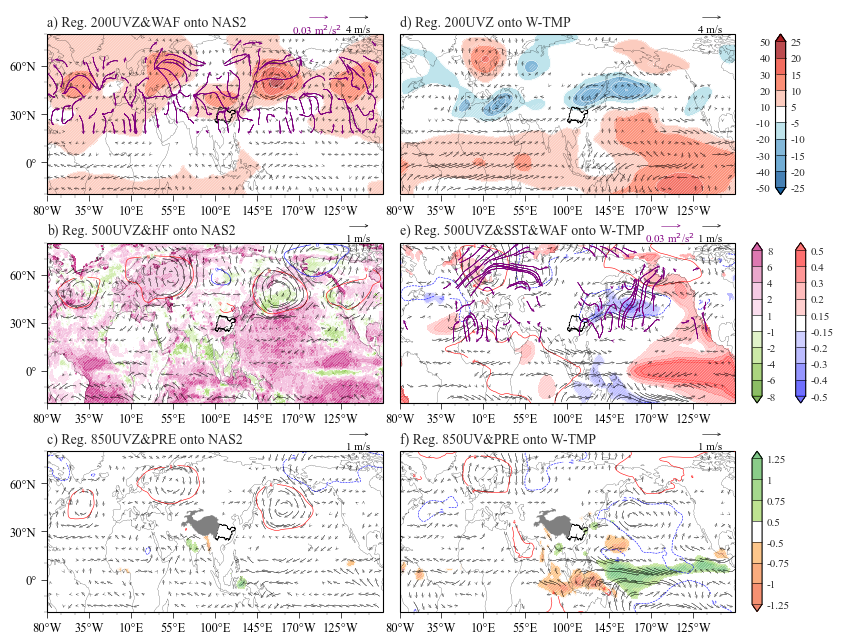

In [52]:
# type3绘图
if 3:
    fig = plt.figure(figsize=(8.88, 7.5))
    fig.subplots_adjust(hspace=0.4)  # Increase vertical spacing between subplots
    xticks1 = np.arange(draw_zone_1[0], draw_zone_1[1], 5)
    yticks1 = np.arange(draw_zone_1[2], draw_zone_1[3], 30)
    #子图间距
    gs = gridspec.GridSpec(3, 2, width_ratios=[1, 1], height_ratios=[1, 1, 1], hspace=0.3, wspace=0.05)
    plt.subplots_adjust(wspace=0.1, hspace=0.05)
    ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=c_lon_1))
    ax1.set_title(f"a) Reg. 200UVZ&WAF onto NAS2", fontsize=10, loc='left')
    ax1.set_extent(draw_zone_1, crs=ccrs.PlateCarree())
    ax1.set_aspect('auto')
    ax1.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.15)
    # ax1.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax1.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(),
                      facecolor='none', edgecolor='black', linewidth=.5)
    # rec(ax1, zone_1, color='green')
    latlon_fmt(ax1, xticks1, yticks1, MultipleLocator(45), MultipleLocator(15), MultipleLocator(30), MultipleLocator(10))
    # 3Dwaf
    Uc = xr.DataArray(U['u'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', U['lat'].data),
                                ('lon', U['lon'].data)])
    Vc = xr.DataArray(V['v'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', V['lat'].data),
                                ('lon', V['lon'].data)])
    Tc = xr.DataArray(T['t'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', T['lat'].data),
                                ('lon', T['lon'].data)])
    GEOa = xr.DataArray(reg_z_1[1:4, :, :],
                        coords=[('level', [150, 200, 500]),
                                ('lat', U['lat'].data),
                                ('lon', U['lon'].data)])
    waf_x, waf_y, waf_z = TN_WAF_3D(Uc, Vc, GEOa, Tc)
    reg_z_, lon = add_cyclic_point(reg_z_1[2, :, :], coord=Z['lon'])
    corr_z_, lon = add_cyclic_point(corr_z_1[2, :, :], coord=Z['lon'])
    # reg_z_ = np.where((np.abs(reg_z_/9.8) < 15), np.nan, reg_z_)
    waf_contf_ = ax1.contourf(lon, Z['lat'], reg_z_/9.8,
                                           levels=np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25])*2,
                                           cmap=cmaps.temp_diff_18lev[2:-2], alpha=0.75,
                                           extend='both',
                                           transform=ccrs.PlateCarree(central_longitude=0))
    waf_cont = ax1.contour(lon, Z['lat'], reg_z_/9.8, colors='white', levels=np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25])*2, linestyles='solid', linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_z_) > p_th, 0, np.nan)

    # 显著性
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#FFFFFF'
    p_hatches = ax1.contourf(lon, Z['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)

    # # z
    # positive_values = reg_z_1[2][reg_z_1[2] > 0]
    # q50_positive = np.round(np.percentile(positive_values, 90)/9.8) if positive_values.size > 0 else 0
    # positive_values = reg_z_1[2][reg_z_1[2] < 0]
    # q50_positive_ = np.round(np.percentile(positive_values, 66.6)/9.8) if positive_values.size > 0 else 0
    # z_high = ax1.contour(lon, Z['lat'], reg_z_/9.8, colors='red', levels=[q50_positive], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    # z_low = ax1.contour(lon, Z['lat'], reg_z_/9.8, colors='blue', levels=[q50_positive_], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    # z_high.clabel(inline=1, fontsize=3)
    # z_low.clabel(inline=1, fontsize=3)
    # waf_contf = ax1.contourf(lon, Z['lat'], reg_z_/9.8,
    #                                        levels=np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25]),
    #                                        cmap=cmaps.temp_diff_18lev[2:-2], alpha=0.75,
    #                                        extend='both',
    #                                        transform=ccrs.PlateCarree(central_longitude=0))
    # waf_cont = ax1.contour(lon, Z['lat'], reg_z_/9.8, colors='white', levels=np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25]), linestyles='solid', linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    # p_test = np.where(np.abs(corr_z_) > p_th, 0, np.nan)
    # #ax1.quiver(lon, Z['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # # 显著性
    # plt.rcParams['hatch.linewidth'] = 0.2
    # plt.rcParams['hatch.color'] = '#FFFFFF'
    # p_hatches = ax1.contourf(lon, Z['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)
    wind = Curlyquiver(ax1, U['lon'], U['lat'], reg_u_1[2, :, :], reg_v_1[2, :, :], thinning=["40%", 'min'],
                                  center_lon=c_lon_1, arrowsize=.5, scale=12, linewidth=0.15, regrid=15,
                                   color='k', nanmax=20/3, MinDistance=[0.2, 0.1])
    wind.key(fig, U=4, label='4 m/s', ud=7.7, edgecolor='none', arrowsize=.5, linewidth=0.4,color='k', fontproperties={'size': 8})
    WAF_cq = Curlyquiver(ax1, waf_x['lon'], waf_x['lat'][:180],
                                  waf_x[1][:180, :], waf_y[1][:180, :], thinning=['50%', 'min'],
                                  regrid=10, center_lon=c_lon_1, arrowsize=.5, scale=3, linewidth=0.4,
                                  color='purple', nanmax=.2, MinDistance=[0.2, 0.1], regrid_reso=2.5)
    WAF_cq.key(fig, U=.03, label='0.03 m$^2$/s$^2$', lr=1.8, ud=7.7, edgecolor='none', arrowsize=.5, linewidth=0.4, fontproperties={'size': 8})
    # 边框显示为黑色
    ax1.grid(False)
    for spine in ax1.spines.values():
        spine.set_edgecolor('black')

    ax2 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree(central_longitude=c_lon_1))
    ax2.set_title(f"b) Reg. 500UVZ&HF onto NAS2", fontsize=10, loc='left')
    ax2.set_extent(draw_zone_1, crs=ccrs.PlateCarree())
    ax2.set_aspect('auto')
    # ax2.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax2.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.15)
    ax2.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='black', linewidth=.5)
    # rec(ax2, zone_1, color='green')
    latlon_fmt(ax2, xticks1, yticks1, MultipleLocator(45), MultipleLocator(15), MultipleLocator(30), MultipleLocator(10))
    # z
    positive_values = reg_z_2[3][reg_z_2[3] > 0]
    q50_positive = np.round(np.percentile(positive_values, 90)/9.8) if positive_values.size > 0 else 0
    positive_values = reg_z_2[3][reg_z_2[3] < 0]
    q50_positive_ = np.round(np.percentile(positive_values, 95)/9.8) if positive_values.size > 0 else 0
    z_high = ax2.contour(Z['lon'], Z['lat'], reg_z_1[3, :, :]/9.8, colors='red', levels=[9], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_low = ax2.contour(Z['lon'], Z['lat'], reg_z_1[3, :, :]/9.8, colors='blue', levels=[q50_positive_], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_high.clabel(inline=1, fontsize=4)
    z_low.clabel(inline=1, fontsize=4)
    reg_radio_, lon = add_cyclic_point(reg_radio_1[:, :], coord=surface_radio['lon'])##########################
    corr_radio_, lon = add_cyclic_point(corr_radio_1[:, :], coord=surface_radio['lon'])##########################
    # reg_sst_ = np.where((np.abs(reg_sst_) < .15), np.nan, reg_sst_)
    # sst
    surf_con = ax2.contourf(lon, surface_radio['lat'], reg_radio_, cmap=cmaps.MPL_PiYG_r[15:64-10] + cmaps.CBR_wet[0] + cmaps.MPL_PiYG_r[-64+10:-15], levels=np.array([-8, -6, -4, -2, -1, 1, 2, 4, 6, 8]), extend='both', alpha=0.75, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none')
    p_test = np.where(np.abs(corr_radio_) > p_th, 0, np.nan)
    #ax2.quiver(lon, Sst['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # 显著性
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#FFFFFF'
    p_hatches = ax2.contourf(lon, surface_radio['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)
    # wind
    wind = Curlyquiver(ax2, U['lon'], U['lat'], reg_u_1[3, :, :], reg_v_1[3, :, :], thinning=["40%", 'min'],
                                  center_lon=c_lon_1, arrowsize=.5, scale=3, linewidth=0.15, regrid=15,
                                  color='k', nanmax=wind.nanmax, MinDistance=[0.2, 0.1])
    wind.key(fig, U=1, label='1 m/s', ud=7.7, edgecolor='none', arrowsize=.5, color='k', linewidth=0.4, fontproperties={'size': 8})
    # 边框显示为黑色
    ax2.grid(False)
    for spine in ax2.spines.values():
        spine.set_edgecolor('black')

    ax3 = fig.add_subplot(gs[2, 0], projection=ccrs.PlateCarree(central_longitude=c_lon_1))
    ax3.set_title(f"c) Reg. 850UVZ&PRE onto NAS2", fontsize=10, loc='left')
    ax3.set_extent(draw_zone_1, crs=ccrs.PlateCarree())
    ax3.set_aspect('auto')
    # ax3.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax3.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.15)
    ax3.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='black', linewidth=.5)
    # rec(ax3, zone_1, color='green')
    ax3.add_geometries(Reader(r'D:\PyFile\map\地图边界数据\青藏高原边界数据总集\TPBoundary_2500m\TPBoundary_2500m.shp').geometries(),
                                   ccrs.PlateCarree(), facecolor='gray', edgecolor='gray', linewidth=.1, hatch='.', zorder=10)
    latlon_fmt(ax3, xticks1, yticks1, MultipleLocator(45), MultipleLocator(15), MultipleLocator(30), MultipleLocator(10))

    reg_pre_da = xr.DataArray(reg_pre_1, coords=[Pre['lat'], Pre['lon']], dims=['lat', 'lon'])
    reg_pre_da = reg_pre_da.interp(
        lat=np.arange(-90, 90, 0.25),
        lon=np.arange(0, 360, 0.25),
        method='linear',
        kwargs={'fill_value': "extrapolate"}
    )

    reg_pre_, reg_pre_da_lon = add_cyclic_point(reg_pre_da.values, coord=reg_pre_da['lon'])
    corr_pre_, lon = add_cyclic_point(corr_pre_1[:, :], coord=Pre['lon'])
    # reg_pre_ = np.where((np.abs(reg_pre_) < .5), np.nan, reg_pre_)
    # pre
    pre = ax3.contourf(reg_pre_da_lon, reg_pre_da['lat'], reg_pre_, cmap=cmaps.MPL_RdYlGn[22+0:56] + cmaps.CBR_wet[0] + cmaps.MPL_RdYlGn[72:106-0], alpha=0.75, levels=[-1.25, -1., -.75, -.5, .5, .75, 1., 1.25], extend='both', transform=ccrs.PlateCarree(central_longitude=0))
    pre_edge = ax3.contour(reg_pre_da_lon, reg_pre_da['lat'], reg_pre_, colors='white', levels=[-1.25, -1., -.75, -.5, .5, .75, 1., 1.25], linestyles='solid',linewidths=0.2, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_pre_) > p_th, 0, np.nan)
    #ax3.quiver(lon, Pre['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # 显著性
    p_hatches = ax3.contourf(lon, Pre['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#FFFFFF'
    # wind
    wind = Curlyquiver(ax3, U['lon'], U['lat'], reg_u_1[4, :, :], reg_v_1[4, :, :], thinning=["40%", 'min'],
                                  center_lon=c_lon_1, arrowsize=.5, scale=3, linewidth=0.15, regrid=15,
                                color='k', nanmax=wind.nanmax, MinDistance=[0.2, 0.1])
    wind.key(fig, U=1, label='1 m/s', ud=7.7, edgecolor='none', arrowsize=.5, color='k', linewidth=0.4, fontproperties={'size': 8})
    # z
    positive_values = reg_z_2[4][reg_z_2[4] > 0]
    q50_positive = np.round(np.percentile(positive_values, 70)/9.8) if positive_values.size > 0 else 0
    positive_values = reg_z_2[4][reg_z_2[4] < 0]
    q50_positive_ = np.round(np.percentile(positive_values, 66.6)/9.8) if positive_values.size > 0 else 0
    z_high = ax3.contour(Z['lon'], Z['lat'], reg_z_1[4, :, :]/9.8, colors='red', levels=[q50_positive], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_low = ax3.contour(Z['lon'], Z['lat'], reg_z_1[4, :, :]/9.8, colors='blue', levels=[q50_positive_], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_high.clabel(inline=1, fontsize=4)
    z_low.clabel(inline=1, fontsize=4)
    # 边框显示为黑色
    ax3.grid(False)
    for spine in ax3.spines.values():
        spine.set_edgecolor('black')

    ax4, ax5, ax6 = ax1, ax2, ax3

    ################################################################右图
    xticks1 = np.arange(draw_zone_2[0], draw_zone_2[1], 5)
    yticks1 = np.arange(draw_zone_2[2], draw_zone_2[3], 30)
    ax1 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree(central_longitude=c_lon_2))
    ax1.set_title(f"d) Reg. 200UVZ onto W-TMP", fontsize=10, loc='left')
    ax1.set_extent(draw_zone_2, crs=ccrs.PlateCarree())
    ax1.set_aspect('auto')
    # ax1.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax1.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.15)
    ax1.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(),
                      facecolor='none', edgecolor='black', linewidth=.5)
    # rec(ax1, zone_2, color='green')
    latlon_fmt(ax1, xticks1, None, MultipleLocator(45), MultipleLocator(15), MultipleLocator(30), MultipleLocator(10))
    # 3Dwaf
    Uc = xr.DataArray(U['u'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', U['lat'].data),
                                ('lon', U['lon'].data)])
    Vc = xr.DataArray(V['v'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', V['lat'].data),
                                ('lon', V['lon'].data)])
    Tc = xr.DataArray(T['t'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', T['lat'].data),
                                ('lon', T['lon'].data)])
    GEOa = xr.DataArray(reg_z_2[1:4, :, :],
                        coords=[('level', [150, 200, 500]),
                                ('lat', U['lat'].data),
                                ('lon', U['lon'].data)])
    waf_x, waf_y, waf_z = TN_WAF_3D(Uc, Vc, GEOa, Tc)
    reg_z_, lon = add_cyclic_point(reg_z_2[2, :, :], coord=Z['lon'])
    corr_z_, lon = add_cyclic_point(corr_z_2[2, :, :], coord=Z['lon'])
    # reg_z_ = np.where((np.abs(reg_z_/9.8) < 5), np.nan, reg_z_)
    waf_contf = ax1.contourf(lon, Z['lat'], reg_z_/9.8,
                                           levels=np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25]),
                                           cmap=cmaps.temp_diff_18lev[2:-2], alpha=0.75,
                                           extend='both',
                                           transform=ccrs.PlateCarree(central_longitude=0))
    waf_cont = ax1.contour(lon, Z['lat'], reg_z_/9.8, colors='white', levels=np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25]), linestyles='solid', linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_z_) > p_th, 0, np.nan)
    #ax1.quiver(lon, Z['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # 显著性
    p_hatches = ax1.contourf(lon, Z['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#FFFFFF'

    wind = Curlyquiver(ax1, U['lon'], U['lat'], reg_u_2[2, :, :], reg_v_2[2, :, :], thinning=["40%", 'min'],
                                  center_lon=c_lon_2, arrowsize=.5, scale=12, linewidth=0.15, regrid=15,
                                   color='k', nanmax=wind.nanmax, MinDistance=[0.2, 0.1])
    wind.key(fig, U=4, label='4 m/s', ud=7.7, edgecolor='none', arrowsize=.5, color='k', linewidth=0.4, fontproperties={'size': 8})
    # 边框显示为黑色
    ax1.grid(False)
    for spine in ax1.spines.values():
        spine.set_edgecolor('black')
    # 色标
    ax1_colorbar = inset_axes(ax1, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.12, 0., 1, 1), bbox_transform=ax1.transAxes, borderpad=0)
    cb1 = plt.colorbar(waf_contf, cax=ax1_colorbar, orientation='vertical', drawedges=True)
    cb1.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    cb1.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    cb1.locator = ticker.FixedLocator(np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25]))
    cb1.set_ticklabels(['-25', '-20', '-15', '-10', '-5', '5', '10', '15', '20', '25'])
    cb1.ax.yaxis.set_ticks_position('right')
    cb1.ax.yaxis.set_label_position('right')
    # cb1.ax.set_ylabel('Right\npic', rotation=0, loc='bottom', fontsize=6)
    cb1.ax.tick_params(length=0, labelsize=8)  # length为刻度线的长度

        # 色标
    ax4_colorbar = inset_axes(ax4, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.12, 0., 1, 1), bbox_transform=ax1.transAxes, borderpad=0)
    cb4 = plt.colorbar(waf_contf_, cax=ax4_colorbar, orientation='vertical', drawedges=True)
    cb4.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    cb4.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    cb4.locator = ticker.FixedLocator(np.array([-50, -40, -30, -20, -10, 10, 20, 30, 40, 50]))
    cb4.set_ticklabels(['-50', '-40', '-30', '-20', '-10', '10', '20', '30', '40', '50'])
    cb4.ax.yaxis.set_ticks_position('left')
    cb4.ax.yaxis.set_label_position('left')
    # cb4.ax.set_ylabel('Left\npic', rotation=0, loc='bottom', fontsize=6)
    cb4.ax.tick_params(length=0, labelsize=8)  # length为刻度线的长度

    ax2 = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree(central_longitude=c_lon_2))
    ax2.set_title(f"e) Reg. 500UVZ&SST&WAF onto W-TMP", fontsize=10, loc='left')
    ax2.set_extent(draw_zone_2, crs=ccrs.PlateCarree())
    ax2.set_aspect('auto')
    # ax2.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax2.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.15)
    ax2.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='black', linewidth=.5)
    # rec(ax2, zone_2, color='green')
    latlon_fmt(ax2, xticks1, None, MultipleLocator(45), MultipleLocator(15), MultipleLocator(30), MultipleLocator(10))
    # z
    positive_values = reg_z_2[3][reg_z_2[3] > 0]
    q50_positive = np.round(np.percentile(positive_values, 33.3)/9.8) if positive_values.size > 0 else 0
    positive_values = reg_z_2[3][reg_z_2[3] < 0]
    q50_positive_ = np.round(np.percentile(positive_values, 66.6)/9.8) if positive_values.size > 0 else 0
    z_high = ax2.contour(Z['lon'], Z['lat'], reg_z_2[3, :, :]/9.8, colors='red', levels=[4], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_low = ax2.contour(Z['lon'], Z['lat'], reg_z_2[3, :, :]/9.8, colors='blue', levels=[q50_positive_], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_high.clabel(inline=1, fontsize=4)
    z_low.clabel(inline=1, fontsize=4)
    reg_sst_, lon = add_cyclic_point(reg_sst_2[:, :], coord=Sst['lon'])
    corr_sst_, lon = add_cyclic_point(corr_sst_2[:, :], coord=Sst['lon'])
    # reg_sst_ = np.where((np.abs(reg_sst_) < .15) | np.isnan(reg_sst_), np.nan, reg_sst_)
    # sst
    sst = ax2.contourf(lon, Sst['lat'], reg_sst_, cmap=cmaps.GMT_polar[2:10] + cmaps.CBR_wet[0] + cmaps.GMT_polar[10:-2], levels=[-.5, -.4, -.3, -.2, -.15, .15, .2, .3, .4, .5], extend='both', alpha=0.75, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_sst_) > p_th, 0, np.nan)
    #ax2.quiver(lon, Sst['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # 显著性
    p_hatches = ax2.contourf(lon, Sst['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#FFFFFF'
    # wind
    wind = Curlyquiver(ax2, U['lon'], U['lat'], reg_u_2[3, :, :], reg_v_2[3, :, :], thinning=["40%", 'min'],
                                  center_lon=c_lon_2, arrowsize=.5, scale=3, linewidth=0.15, regrid=15,
                                  color='k', nanmax=wind.nanmax, MinDistance=[0.2, 0.1])
    wind.key(fig, U=1, label='1 m/s', ud=7.7, edgecolor='none', arrowsize=.5, color='k', linewidth=0.4, fontproperties={'size': 8})
    WAF_cq = Curlyquiver(ax2, waf_x['lon'], waf_x['lat'][:180], waf_x[2][:180, :], waf_y[2][:180, :], thinning=['75%', 'min'], regrid=10, center_lon=c_lon_2, arrowsize=.5, scale=3, linewidth=0.4, color='purple', nanmax=.2, MinDistance=[0.2, 0.1], regrid_reso=2.5)
    WAF_cq.key(fig, U=.03, label='0.03 m$^2$/s$^2$', lr=1.8, ud=7.7, edgecolor='none', arrowsize=.5, linewidth=0.4, fontproperties={'size': 8})
    # 边框显示为黑色
    ax2.grid(False)
    for spine in ax2.spines.values():
        spine.set_edgecolor('black')
    # 色条
    ax2_colorbar = inset_axes(ax2, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.18, 0., 1, 1), bbox_transform=ax2.transAxes, borderpad=0)
    cb2 = plt.colorbar(sst, cax=ax2_colorbar, orientation='vertical', drawedges=True)
    cb2.locator = ticker.FixedLocator(np.array([-.5, -.4, -.3, -.2,-.15, .15,.2,.3,.4,.5]))
    cb2.set_ticklabels(['-0.5', '-0.4', '-0.3', '-0.2', '-0.15', '0.15', '0.2', '0.3', '0.4', '0.5'])
    cb2.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    cb2.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    cb2.ax.tick_params(length=0, labelsize=8)  # length为刻度线的长度

    # 色条
    ax5_colorbar = inset_axes(ax5, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax2.transAxes, borderpad=0)
    cb5 = plt.colorbar(surf_con, cax=ax5_colorbar, orientation='vertical', drawedges=True)
    cb5.locator = ticker.FixedLocator(np.array([-8, -6, -4, -2, -1, 1, 2, 4, 6, 8]))
    cb5.set_ticklabels(['-8', '-6', '-4', '-2', '-1', '1', '2', '4', '6', '8'])
    cb5.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    cb5.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    cb5.ax.tick_params(length=0, labelsize=8)  # length为刻度线的长度

    ax3 = fig.add_subplot(gs[2, 1], projection=ccrs.PlateCarree(central_longitude=c_lon_2))
    ax3.set_title(f"f) Reg. 850UV&PRE onto W-TMP", fontsize=10, loc='left')
    ax3.set_extent(draw_zone_2, crs=ccrs.PlateCarree())
    ax3.set_aspect('auto')
    # ax3.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax3.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.15)
    ax3.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='black', linewidth=.5)
    # rec(ax3, zone_2, color='green')
    ax3.add_geometries(Reader(r'D:\PyFile\map\地图边界数据\青藏高原边界数据总集\TPBoundary_2500m\TPBoundary_2500m.shp').geometries(),
                                   ccrs.PlateCarree(), facecolor='gray', edgecolor='gray', linewidth=.1, hatch='.', zorder=10)
    latlon_fmt(ax3, xticks1, None, MultipleLocator(45), MultipleLocator(15), MultipleLocator(30), MultipleLocator(10))

    reg_pre_da = xr.DataArray(reg_pre_2, coords=[Pre['lat'], Pre['lon']], dims=['lat', 'lon'])
    reg_pre_da = reg_pre_da.interp(
        lat=np.arange(-90, 90, 0.25),
        lon=np.arange(0, 360, 0.25),
        method='linear',
        kwargs={'fill_value': "extrapolate"}
    )

    reg_pre_, reg_pre_da_lon = add_cyclic_point(reg_pre_da.values, coord=reg_pre_da['lon'])
    corr_pre_, lon = add_cyclic_point(corr_pre_2[:, :], coord=Pre['lon'])
    # reg_pre_ = np.where((np.abs(reg_pre_) < .5), np.nan, reg_pre_)
    # pre
    pre = ax3.contourf(reg_pre_da_lon, reg_pre_da['lat'], reg_pre_, cmap=cmaps.MPL_RdYlGn[22+0:56] + cmaps.CBR_wet[0] + cmaps.MPL_RdYlGn[72:106-0], alpha=0.75, levels=[-1.25, -1., -.75, -.5, .5, .75, 1., 1.25], extend='both', transform=ccrs.PlateCarree(central_longitude=0))
    pre_edge = ax3.contour(reg_pre_da_lon, reg_pre_da['lat'], reg_pre_, colors='white', levels=[-1.25, -1., -.75, -.5, .5, .75, 1., 1.25], linestyles='solid',linewidths=0.2, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_pre_) > p_th, 0, np.nan)
    #ax3.quiver(lon, Pre['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # 显著性
    p_hatches = ax3.contourf(lon, Pre['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#FFFFFF'
    # wind
    wind = Curlyquiver(ax3, U['lon'], U['lat'], reg_u_2[4, :, :], reg_v_2[4, :, :], thinning=["40%", 'min'],
                                  center_lon=c_lon_2, arrowsize=.5, scale=3, linewidth=0.15, regrid=15,
                                color='k', nanmax=wind.nanmax, MinDistance=[0.2, 0.1])
    wind.key(fig, U=1, label='1 m/s', ud=7.7, edgecolor='none', arrowsize=.5, color='k', linewidth=0.4, fontproperties={'size': 8})
    # z
    positive_values = reg_z_2[4][reg_z_2[4] > 0]
    q50_positive = np.round(np.percentile(positive_values, 33.3)/9.8) if positive_values.size > 0 else 0
    positive_values = reg_z_2[4][reg_z_2[4] < 0]
    q50_positive_ = np.round(np.percentile(positive_values, 66.6)/9.8) if positive_values.size > 0 else 0
    z_high = ax3.contour(Z['lon'], Z['lat'], reg_z_2[4, :, :]/9.8, colors='red', levels=[4], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_low = ax3.contour(Z['lon'], Z['lat'], reg_z_2[4, :, :]/9.8, colors='blue', levels=[q50_positive_], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_high.clabel(inline=1, fontsize=4)
    z_low.clabel(inline=1, fontsize=4)
    # 边框显示为黑色
    ax3.grid(False)
    for spine in ax3.spines.values():
        spine.set_edgecolor('black')
    # 色条
    ax3_colorbar = inset_axes(ax3, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax3.transAxes, borderpad=0)
    cb3 = plt.colorbar(pre, cax=ax3_colorbar, orientation='vertical', drawedges=True)
    cb3.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    cb3.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    cb3.locator = ticker.FixedLocator(np.array([-1.25, -1., -.75, -.5, .5, .75, 1., 1.25]))
    cb3.set_ticklabels(['-1.25', '-1', '-0.75', '-0.5', '0.5', '0.75', '1', '1.25'])
    cb3.ax.tick_params(length=0, labelsize=8)  # length为刻度线的长度


    plt.savefig(f'D:/PyFile/p2/pic/回归场3.png', dpi=600, bbox_inches='tight')
    plt.show()


C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)
C:\Users\86136\.conda\envs\Meteorological\lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'add_colorbar', 'edgecolor'
  result = super().contourf(*args, **kwargs)
D:\Code\work\Meteorological\toolbar\curved_quivers\modplot.py:275: UserWarning: 已将Y轴反转，因为Y轴坐标轴为非增长序列。
  warnings.warn('已将Y轴反转，因为Y轴坐标轴为非增长序列。', UserWarning)
路径积分: 100%|██████████| 700/700 [00:10<00:00, 68.66points/s] 
D:\Code\work\Meteorological\toolbar\curved_quivers\modplot.py:275: UserWarning: 已将Y轴反转，因为Y轴坐标轴为非增长序列。
  warnings.warn('已将Y轴反转，因为Y轴坐标轴为非增长序列。', UserWarning)
D:\Code\work\Meteorological\toolbar\curved_quivers\modplot.py:360: UserWarning: 高纬地区数据缺测，已进行延拓(fill np.nan)
  warnings.warn('高纬地区数据缺测，已进行延拓(fill np.nan)', UserWarning)
D:\Code\work\Meteorological\toolbar\curved_quivers\modpl

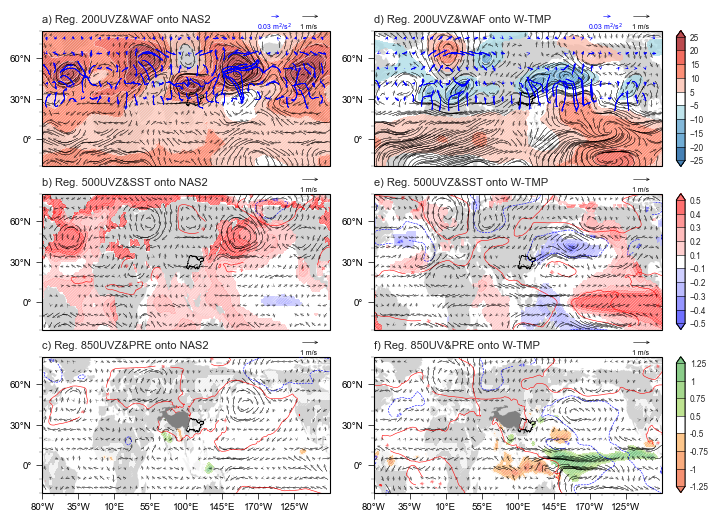

In [19]:
# type3绘图
if 3:
    fig = plt.figure(figsize=(8, 6))
    fig.subplots_adjust(hspace=0.4)  # Increase vertical spacing between subplots
    xticks1 = np.arange(draw_zone_1[0], draw_zone_1[1], 5)
    yticks1 = np.arange(draw_zone_1[2], draw_zone_1[3], 30)
    #子图间距
    gs = gridspec.GridSpec(3, 2, width_ratios=[1, 1], height_ratios=[1, 1, 1], wspace=0.15, hspace=0.2)
    plt.subplots_adjust(wspace=0.1, hspace=0.05)
    ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=c_lon_1))
    ax1.set_title(f"a) Reg. 200UVZ&WAF onto NAS2", fontsize=8, loc='left')
    ax1.set_extent(draw_zone_1, crs=ccrs.PlateCarree())
    ax1.set_aspect('auto')
    ax1.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax1.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(),
                      facecolor='none', edgecolor='black', linewidth=.5)
    # rec(ax1, zone_1, color='green')
    latlon_fmt(ax1, None, yticks1, MultipleLocator(45), MultipleLocator(15), MultipleLocator(30), MultipleLocator(10))
    # 3Dwaf
    Uc = xr.DataArray(U['u'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', U['lat'].data),
                                ('lon', U['lon'].data)])
    Vc = xr.DataArray(V['v'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', V['lat'].data),
                                ('lon', V['lon'].data)])
    Tc = xr.DataArray(T['t'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', T['lat'].data),
                                ('lon', T['lon'].data)])
    GEOa = xr.DataArray(reg_z_1[1:4, :, :],
                        coords=[('level', [150, 200, 500]),
                                ('lat', U['lat'].data),
                                ('lon', U['lon'].data)])
    waf_x, waf_y, waf_z = TN_WAF_3D(Uc, Vc, GEOa, Tc)
    reg_z_, lon = add_cyclic_point(reg_z_1[2, :, :], coord=Z['lon'])
    corr_z_, lon = add_cyclic_point(corr_z_1[2, :, :], coord=Z['lon'])
    reg_z_ = np.where((np.abs(reg_z_/9.8) < 5), np.nan, reg_z_)
    waf_contf = ax1.contourf(lon, Z['lat'], reg_z_/9.8,
                                           levels=np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25]),
                                           cmap=cmaps.temp_diff_18lev[2:-2], alpha=0.75,
                                           extend='both',
                                           transform=ccrs.PlateCarree(central_longitude=0))
    waf_cont = ax1.contour(lon, Z['lat'], reg_z_/9.8, colors='white', levels=np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25]), linestyles='solid', linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_z_) > p_th, 0, np.nan)
    #ax1.quiver(lon, Z['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # 显著性
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#FFFFFF'
    p_hatches = ax1.contourf(lon, Z['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)
    wind = Curlyquiver(ax1, U['lon'], U['lat'], reg_u_1[2, :, :], reg_v_1[2, :, :], thinning=[0.2, 'min'],
                                  center_lon=c_lon_1, arrowsize=.5, scale=3, linewidth=0.15, regrid=15,
                                   color='k', nanmax=20/3)
    wind.key(fig, U=1, label='1 m/s', ud=7.7, edgecolor='none', arrowsize=.5, linewidth=0.4,color='k')
    waf_speed = np.sqrt(waf_x[1] ** 2 + waf_y[1] ** 2)
    waf_speed_50 = np.nanpercentile(waf_speed, 20)
    waf_speed_mask = np.where(waf_speed > waf_speed_50, 1, 0)
    waf_x_mask = waf_speed_mask * waf_x[1]
    waf_y_mask = waf_speed_mask * waf_y[1]
    WAF_cq = Curlyquiver(ax1, waf_x['lon'], waf_x['lat'][:180],
                                  waf_x_mask[:180, :], waf_y_mask[:180, :], thinning=['25%', 'min'],
                                  regrid=10, center_lon=c_lon_1, arrowsize=.5, scale=7.5, linewidth=0.4,
                                  color='blue', nanmax=.2)
    WAF_cq.key(fig, U=.03, label='0.03 m$^2$/s$^2$', lr=1.8, ud=7.7, edgecolor='none', arrowsize=.5, linewidth=0.4)
    # 边框显示为黑色
    ax1.grid(False)
    for spine in ax1.spines.values():
        spine.set_edgecolor('black')

    ax2 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree(central_longitude=c_lon_1))
    ax2.set_title(f"b) Reg. 500UVZ&SST onto NAS2", fontsize=8, loc='left')
    ax2.set_extent(draw_zone_1, crs=ccrs.PlateCarree())
    ax2.set_aspect('auto')
    ax2.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax2.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='black', linewidth=.5)
    # rec(ax2, zone_1, color='green')
    latlon_fmt(ax2, None, yticks1, MultipleLocator(45), MultipleLocator(15), MultipleLocator(30), MultipleLocator(10))
    # z
    positive_values = reg_z_2[3][reg_z_2[3] > 0]
    q50_positive = np.round(np.percentile(positive_values, 33.3)) if positive_values.size > 0 else 0
    positive_values = reg_z_2[3][reg_z_2[3] < 0]
    q50_positive_ = np.round(np.percentile(positive_values, 66.6)) if positive_values.size > 0 else 0
    z_high = ax2.contour(Z['lon'], Z['lat'], reg_z_1[3, :, :], colors='red', levels=[q50_positive], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_low = ax2.contour(Z['lon'], Z['lat'], reg_z_1[3, :, :], colors='blue', levels=[q50_positive_], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_high.clabel(inline=1, fontsize=3)
    z_low.clabel(inline=1, fontsize=3)
    reg_sst_, lon = add_cyclic_point(reg_sst_1[:, :], coord=Sst['lon'])
    corr_sst_, lon = add_cyclic_point(corr_sst_1[:, :], coord=Sst['lon'])
    reg_sst_ = np.where((np.abs(reg_sst_) < .1), np.nan, reg_sst_)
    # sst
    sst = ax2.contourf(lon, Sst['lat'], reg_sst_, cmap=cmaps.GMT_polar[2:10] + cmaps.CBR_wet[0] + cmaps.GMT_polar[10:-2], levels=[-.5, -.4, -.3, -.2, -.1, .1, .2, .3, .4, .5], extend='both', alpha=0.75, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_sst_) > p_th, 0, np.nan)
    #ax2.quiver(lon, Sst['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # 显著性
    p_hatches = ax2.contourf(lon, Sst['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#FFFFFF'
    # wind
    wind = Curlyquiver(ax2, U['lon'], U['lat'], reg_u_1[3, :, :], reg_v_1[3, :, :], thinning=[0.1, 'min'],
                                  center_lon=c_lon_1, arrowsize=.5, scale=3, linewidth=0.15, regrid=15,
                                  color='k', nanmax=wind.nanmax)
    wind.key(fig, U=1, label='1 m/s', ud=7.7, edgecolor='none', arrowsize=.5, color='k', linewidth=0.4)
    # 边框显示为黑色
    ax2.grid(False)
    for spine in ax2.spines.values():
        spine.set_edgecolor('black')

    ax3 = fig.add_subplot(gs[2, 0], projection=ccrs.PlateCarree(central_longitude=c_lon_1))
    ax3.set_title(f"c) Reg. 850UVZ&PRE onto NAS2", fontsize=8, loc='left')
    ax3.set_extent(draw_zone_1, crs=ccrs.PlateCarree())
    ax3.set_aspect('auto')
    ax3.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax3.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='black', linewidth=.5)
    # rec(ax3, zone_1, color='green')
    ax3.add_geometries(Reader(r'D:\PyFile\map\地图边界数据\青藏高原边界数据总集\TPBoundary_2500m\TPBoundary_2500m.shp').geometries(),
                                   ccrs.PlateCarree(), facecolor='gray', edgecolor='gray', linewidth=.1, hatch='.', zorder=10)
    latlon_fmt(ax3, xticks1, yticks1, MultipleLocator(45), MultipleLocator(15), MultipleLocator(30), MultipleLocator(10))
    reg_pre_, lon = add_cyclic_point(reg_pre_1[:, :], coord=Pre['lon'])
    corr_pre_, lon = add_cyclic_point(corr_pre_1[:, :], coord=Pre['lon'])
    reg_pre_ = np.where((np.abs(reg_pre_) < .1), np.nan, reg_pre_)
    # pre
    pre = ax3.contourf(lon, Pre['lat'], reg_pre_, cmap=cmaps.MPL_RdYlGn[22+0:56] + cmaps.CBR_wet[0] + cmaps.MPL_RdYlGn[72:106-0], alpha=0.75, levels=[-1.25, -1., -.75, -.5, .5, .75, 1., 1.25], extend='both', transform=ccrs.PlateCarree(central_longitude=0))
    pre_edge = ax3.contour(lon, Pre['lat'], reg_pre_, colors='white', levels=[-1.25, -1., -.75, -.5, .5, .75, 1., 1.25], linestyles='solid',linewidths=0.2, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_pre_) > p_th, 0, np.nan)
    #ax3.quiver(lon, Pre['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # 显著性
    p_hatches = ax3.contourf(lon, Pre['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#FFFFFF'
    # wind
    wind = Curlyquiver(ax3, U['lon'], U['lat'], reg_u_1[4, :, :], reg_v_1[4, :, :], thinning=[0.1, 'min'],
                                  center_lon=c_lon_1, arrowsize=.5, scale=3, linewidth=0.15, regrid=15,
                                color='k', nanmax=wind.nanmax)
    wind.key(fig, U=1, label='1 m/s', ud=7.7, edgecolor='none', arrowsize=.5, color='k', linewidth=0.4)
    # z
    positive_values = reg_z_2[4][reg_z_2[4] > 0]
    q50_positive = np.round(np.percentile(positive_values, 33.3)) if positive_values.size > 0 else 0
    positive_values = reg_z_2[4][reg_z_2[4] < 0]
    q50_positive_ = np.round(np.percentile(positive_values, 66.6)) if positive_values.size > 0 else 0
    z_high = ax3.contour(Z['lon'], Z['lat'], reg_z_1[4, :, :], colors='red', levels=[q50_positive], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_low = ax3.contour(Z['lon'], Z['lat'], reg_z_1[4, :, :], colors='blue', levels=[q50_positive_], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_high.clabel(inline=1, fontsize=3)
    z_low.clabel(inline=1, fontsize=3)
    # 边框显示为黑色
    ax3.grid(False)
    for spine in ax3.spines.values():
        spine.set_edgecolor('black')

    ax4, ax5, ax6 = ax1, ax2, ax3

    ################################################################右图
    xticks1 = np.arange(draw_zone_2[0], draw_zone_2[1], 5)
    yticks1 = np.arange(draw_zone_2[2], draw_zone_2[3], 30)
    ax1 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree(central_longitude=c_lon_2))
    ax1.set_title(f"d) Reg. 200UVZ&WAF onto W-TMP", fontsize=8, loc='left')
    ax1.set_extent(draw_zone_2, crs=ccrs.PlateCarree())
    ax1.set_aspect('auto')
    ax1.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax1.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(),
                      facecolor='none', edgecolor='black', linewidth=.5)
    # rec(ax1, zone_2, color='green')
    latlon_fmt(ax1, None, yticks1, MultipleLocator(45), MultipleLocator(15), MultipleLocator(30), MultipleLocator(10))
    # 3Dwaf
    Uc = xr.DataArray(U['u'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', U['lat'].data),
                                ('lon', U['lon'].data)])
    Vc = xr.DataArray(V['v'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', V['lat'].data),
                                ('lon', V['lon'].data)])
    Tc = xr.DataArray(T['t'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', T['lat'].data),
                                ('lon', T['lon'].data)])
    GEOa = xr.DataArray(reg_z_2[1:4, :, :],
                        coords=[('level', [150, 200, 500]),
                                ('lat', U['lat'].data),
                                ('lon', U['lon'].data)])
    waf_x, waf_y, waf_z = TN_WAF_3D(Uc, Vc, GEOa, Tc)
    reg_z_, lon = add_cyclic_point(reg_z_2[2, :, :], coord=Z['lon'])
    corr_z_, lon = add_cyclic_point(corr_z_2[2, :, :], coord=Z['lon'])
    reg_z_ = np.where((np.abs(reg_z_/9.8) < 5), np.nan, reg_z_)
    waf_contf = ax1.contourf(lon, Z['lat'], reg_z_/9.8,
                                           levels=np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25]),
                                           cmap=cmaps.temp_diff_18lev[2:-2], alpha=0.75,
                                           extend='both',
                                           transform=ccrs.PlateCarree(central_longitude=0))
    waf_cont = ax1.contour(lon, Z['lat'], reg_z_/9.8, colors='white', levels=np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25]), linestyles='solid', linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_z_) > p_th, 0, np.nan)
    #ax1.quiver(lon, Z['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # 显著性
    p_hatches = ax1.contourf(lon, Z['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#FFFFFF'

    wind = Curlyquiver(ax1, U['lon'], U['lat'], reg_u_2[2, :, :], reg_v_2[2, :, :], thinning=[0.2, 'min'],
                                  center_lon=c_lon_2, arrowsize=.5, scale=3, linewidth=0.15, regrid=15,
                                   color='k', nanmax=wind.nanmax)
    wind.key(fig, U=1, label='1 m/s', ud=7.7, edgecolor='none', arrowsize=.5, color='k', linewidth=0.4)
    waf_speed = np.sqrt(waf_x[1] ** 2 + waf_y[1] ** 2)
    waf_speed_50 = np.nanpercentile(waf_speed, 20)
    waf_speed_mask = np.where(waf_speed > waf_speed_50, 1, 0)
    waf_x_mask = waf_speed_mask * waf_x[1]
    waf_y_mask = waf_speed_mask * waf_y[1]
    WAF_cq = Curlyquiver(ax1, waf_x['lon'], waf_x['lat'][:180],
                                  waf_x_mask[:180, :], waf_y_mask[:180, :], thinning=['25%', 'min'],
                                  regrid=10, center_lon=c_lon_2, arrowsize=.5, scale=7.5, linewidth=0.4,
                                  color='blue', nanmax=.2)
    WAF_cq.key(fig, U=.03, label='0.03 m$^2$/s$^2$', lr=1.8, ud=7.7, edgecolor='none', arrowsize=.5, linewidth=0.4)
    # 边框显示为黑色
    ax1.grid(False)
    for spine in ax1.spines.values():
        spine.set_edgecolor('black')
    # 色标
    ax1_colorbar = inset_axes(ax1, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax1.transAxes, borderpad=0)
    cb1 = plt.colorbar(waf_contf, cax=ax1_colorbar, orientation='vertical', drawedges=True)
    cb1.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    cb1.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    cb1.locator = ticker.FixedLocator(np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25]))
    #cb1.set_ticklabels(['-30', '-25', '-20', '-15', '-10', '-5', '5', '10', '15', '20', '25', '30'])
    cb1.ax.tick_params(length=0, labelsize=6)  # length为刻度线的长度

    ax2 = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree(central_longitude=c_lon_2))
    ax2.set_title(f"e) Reg. 500UVZ&SST onto W-TMP", fontsize=8, loc='left')
    ax2.set_extent(draw_zone_2, crs=ccrs.PlateCarree())
    ax2.set_aspect('auto')
    ax2.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax2.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='black', linewidth=.5)
    # rec(ax2, zone_2, color='green')
    latlon_fmt(ax2, None, yticks1, MultipleLocator(45), MultipleLocator(15), MultipleLocator(30), MultipleLocator(10))
    # z
    positive_values = reg_z_2[3][reg_z_2[3] > 0]
    q50_positive = np.round(np.percentile(positive_values, 33.3)) if positive_values.size > 0 else 0
    positive_values = reg_z_2[3][reg_z_2[3] < 0]
    q50_positive_ = np.round(np.percentile(positive_values, 66.6)) if positive_values.size > 0 else 0
    z_high = ax2.contour(Z['lon'], Z['lat'], reg_z_2[3, :, :], colors='red', levels=[q50_positive], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_low = ax2.contour(Z['lon'], Z['lat'], reg_z_2[3, :, :], colors='blue', levels=[q50_positive_], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_high.clabel(inline=1, fontsize=3)
    z_low.clabel(inline=1, fontsize=3)
    reg_sst_, lon = add_cyclic_point(reg_sst_2[:, :], coord=Sst['lon'])
    corr_sst_, lon = add_cyclic_point(corr_sst_2[:, :], coord=Sst['lon'])
    reg_sst_ = np.where((np.abs(reg_sst_) < .1), np.nan, reg_sst_)
    # sst
    sst = ax2.contourf(lon, Sst['lat'], reg_sst_, cmap=cmaps.GMT_polar[2:10] + cmaps.CBR_wet[0] + cmaps.GMT_polar[10:-2], levels=[-.5, -.4, -.3, -.2, -.1, .1, .2, .3, .4, .5], extend='both', alpha=0.75, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_sst_) > p_th, 0, np.nan)
    #ax2.quiver(lon, Sst['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # 显著性
    p_hatches = ax2.contourf(lon, Sst['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#FFFFFF'
    # wind
    wind = Curlyquiver(ax2, U['lon'], U['lat'], reg_u_2[3, :, :], reg_v_2[3, :, :], thinning=[0.1, 'min'],
                                  center_lon=c_lon_2, arrowsize=.5, scale=3, linewidth=0.15, regrid=15,
                                  color='k', nanmax=wind.nanmax)
    wind.key(fig, U=1, label='1 m/s', ud=7.7, edgecolor='none', arrowsize=.5, color='k', linewidth=0.4)
    # 边框显示为黑色
    ax2.grid(False)
    for spine in ax2.spines.values():
        spine.set_edgecolor('black')
    # 色条
    ax2_colorbar = inset_axes(ax2, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax2.transAxes, borderpad=0)
    cb2 = plt.colorbar(sst, cax=ax2_colorbar, orientation='vertical', drawedges=True)
    cb2.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    cb2.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    cb2.ax.tick_params(length=0, labelsize=6)  # length为刻度线的长度

    ax3 = fig.add_subplot(gs[2, 1], projection=ccrs.PlateCarree(central_longitude=c_lon_2))
    ax3.set_title(f"f) Reg. 850UV&PRE onto W-TMP", fontsize=8, loc='left')
    ax3.set_extent(draw_zone_2, crs=ccrs.PlateCarree())
    ax3.set_aspect('auto')
    ax3.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax3.add_geometries(Reader(r'D:\PyFile\map\self\长江_TP\长江_tp.shp').geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='black', linewidth=.5)
    # rec(ax3, zone_2, color='green')
    ax3.add_geometries(Reader(r'D:\PyFile\map\地图边界数据\青藏高原边界数据总集\TPBoundary_2500m\TPBoundary_2500m.shp').geometries(),
                                   ccrs.PlateCarree(), facecolor='gray', edgecolor='gray', linewidth=.1, hatch='.', zorder=10)
    latlon_fmt(ax3, xticks1, yticks1, MultipleLocator(45), MultipleLocator(15), MultipleLocator(30), MultipleLocator(10))
    reg_pre_, lon = add_cyclic_point(reg_pre_2[:, :], coord=Pre['lon'])
    corr_pre_, lon = add_cyclic_point(corr_pre_2[:, :], coord=Pre['lon'])
    reg_pre_ = np.where((np.abs(reg_pre_) < .1), np.nan, reg_pre_)
    # pre
    pre = ax3.contourf(lon, Pre['lat'], reg_pre_, cmap=cmaps.MPL_RdYlGn[22+0:56] + cmaps.CBR_wet[0] + cmaps.MPL_RdYlGn[72:106-0], alpha=0.75, levels=[-1.25, -1., -.75, -.5, .5, .75, 1., 1.25], extend='both', transform=ccrs.PlateCarree(central_longitude=0))
    pre_edge = ax3.contour(lon, Pre['lat'], reg_pre_, colors='white', levels=[-1.25, -1., -.75, -.5, .5, .75, 1., 1.25], linestyles='solid',linewidths=0.2, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_pre_) > p_th, 0, np.nan)
    #ax3.quiver(lon, Pre['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # 显著性
    p_hatches = ax3.contourf(lon, Pre['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#FFFFFF'
    # wind
    wind = Curlyquiver(ax3, U['lon'], U['lat'], reg_u_2[4, :, :], reg_v_2[4, :, :], thinning=[0.1, 'min'],
                                  center_lon=c_lon_2, arrowsize=.5, scale=3, linewidth=0.15, regrid=15,
                                color='k', nanmax=wind.nanmax)
    wind.key(fig, U=1, label='1 m/s', ud=7.7, edgecolor='none', arrowsize=.5, color='k', linewidth=0.4)
    # z
    positive_values = reg_z_2[4][reg_z_2[4] > 0]
    q50_positive = np.round(np.percentile(positive_values, 33.3)) if positive_values.size > 0 else 0
    positive_values = reg_z_2[4][reg_z_2[4] < 0]
    q50_positive_ = np.round(np.percentile(positive_values, 66.6)) if positive_values.size > 0 else 0
    z_high = ax3.contour(Z['lon'], Z['lat'], reg_z_2[4, :, :], colors='red', levels=[q50_positive], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_low = ax3.contour(Z['lon'], Z['lat'], reg_z_2[4, :, :], colors='blue', levels=[q50_positive_], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    z_high.clabel(inline=1, fontsize=3)
    z_low.clabel(inline=1, fontsize=3)
    # 边框显示为黑色
    ax3.grid(False)
    for spine in ax3.spines.values():
        spine.set_edgecolor('black')
    # 色条
    ax3_colorbar = inset_axes(ax3, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax3.transAxes, borderpad=0)
    cb3 = plt.colorbar(pre, cax=ax3_colorbar, orientation='vertical', drawedges=True)
    cb3.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    cb3.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    cb3.locator = ticker.FixedLocator(np.array([-1.25, -1., -.75, -.5, .5, .75, 1., 1.25]))
    cb3.set_ticklabels(['-1.25', '-1', '-0.75', '-0.5', '0.5', '0.75', '1', '1.25'])
    cb3.ax.tick_params(length=0, labelsize=6)  # length为刻度线的长度


    plt.savefig(f'D:/PyFile/p2/pic/回归场3.png', dpi=600, bbox_inches='tight')
    plt.show()
